# **Setup**

In [ ]:
from google.colab import drive

download = False

if not download:
  drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!pwd

/content/drive/My Drive


In [ ]:
import os, os.path
!pip install pyunpack patool rarfile segmentation-models git+https://github.com/davej23/image-segmentation-keras.git rioxarray geopandas fiona pyshp keras_unet_collection
from matplotlib import pyplot as plt
import rasterio
from rasterio.windows import get_data_window
from rasterio.windows import Window
import rasterio.mask
import numpy as np
import rioxarray as rxr
from skimage.io import imread
import tensorflow as tf
from osgeo import gdal

  Cloning https://github.com/davej23/image-segmentation-keras.git to /tmp/pip-req-build-zq8x9jjv
  Running command git clone --filter=blob:none --quiet https://github.com/davej23/image-segmentation-keras.git /tmp/pip-req-build-zq8x9jjv
  Resolved https://github.com/davej23/image-segmentation-keras.git to commit e01b0a8d5859854cd9d259a618829889166439f5
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 71.0 MB/s eta 0:00:00
    

In [ ]:
!cp -r drive/Mydrive/Output drive/MyDrive/paramo_ml/Output .

cp: cannot stat 'drive/Mydrive/Output': No such file or directory
^C


In [ ]:
!cp -r drive/MyDrive/paramo_ml/Output .

cp: cannot open 'drive/MyDrive/paramo_ml/Output/metrics_im_only_trainedmore.gsheet' for reading: Operation not supported
cp: cannot open 'drive/MyDrive/paramo_ml/Output/metrics_im_only_512x512_trainedmorept2.gsheet' for reading: Operation not supported
cp: cannot open 'drive/MyDrive/paramo_ml/Output/metrics_im_only_512x512_short_new.gsheet' for reading: Operation not supported
cp: cannot open 'drive/MyDrive/paramo_ml/Output/results.gdoc' for reading: Operation not supported
cp: cannot open 'drive/MyDrive/paramo_ml/Output/metrics_im_only_512x512_avgs.gsheet' for reading: Operation not supported


In [ ]:
def save_to_drive():
  !cp -r Output/ sv_para/

# **Data preparation**

### Loading entire image into memory


*   Reads entire image into memory
*   Splits into HxW tiles
*   Finds good short masks (tiles with short plants inside)
*   Finds good tall masks





In [ ]:
def load_and_split_image(path, tileSize, offset=(0, 0), channels=3):
    full_img_og = np.array(rxr.open_rasterio(path))
    full_img_og = full_img_og.T

    if offset[0] == 0 and offset[1] == 0:
        full_img = full_img_og[:, :, :]
    else:
        full_img = full_img_og[offset[0]:offset[1], offset[0]:offset[1], :]

    all_ims = []
    for i in range(full_img.shape[0] // tileSize):
        for j in range(full_img.shape[1] // tileSize):
            all_ims.append(full_img[tileSize*(i):tileSize*(i+1), tileSize*(j):tileSize*(j+1), :].reshape(tileSize,tileSize,channels))

    return all_ims

In [ ]:

import os

print(os.getcwd())


# 修改工作路径
import os
from google.colab import drive

path = "/content/drive/MyDrive"
os.chdir(path)

/content


In [ ]:
print(os.getcwd())

/content/drive/MyDrive


In [ ]:
tileSize = 512
#tileSize = 128  #(some models need)
# Ingest tall plant mask
full_mask_og = np.array(rxr.open_rasterio('labels/paramo_label_final/tall_mask_new.tif'))
full_mask_og = full_mask_og.T
# full_mask = full_mask_og[5000:13192, 5000:13192, :] # This is a region which contains tall and short plants
full_mask = full_mask_og[:, :, :]

# Ingest short plant mask
full_mask_og_short = np.array(rxr.open_rasterio('labels/paramo_label_final/short_mask_new.tif'))
full_mask_og_short = full_mask_og_short.T
# full_mask_short = full_mask_og_short[5000:13192, 5000:13192, :]
full_mask_short = full_mask_og_short[:, :, :]

# Split into tileSize x tileSize images and masks
all_masks = []
for i in range(full_mask.shape[0] // tileSize):
  for j in range(full_mask.shape[1] // tileSize):
    all_masks.append(full_mask[tileSize*(i):tileSize*(i+1), tileSize*(j):tileSize*(j+1), :].reshape(tileSize,tileSize,1))

# Find indices of masks and images which have at least one plant in
# masks = []
# ind = []
# tot = []
# for i in range(len(all_masks)):
#   if np.sum(all_masks[i]) > 0: # If sum of mask pixels is > 0, some plants in
#     masks.append(all_masks[i])
#     tot.append([i, np.sum(all_masks[i])])
#     ind.append(i)

## Uncomment the next three lines if wanting to use masks with top n_top plants in
#n_top = 100
#tot = sorted(tot, key=lambda x: x[1], reverse=True)
#tot = tot[0:n_top]
#ind = [n[0] for n in tot]

# Read image data
full_img_og = np.array(rxr.open_rasterio('images/drone_paramo/DUI-01-1_ortho.tif'))
full_img_og = full_img_og.T
# full_img = full_img_og[5000:13192, 5000:13192, :]
full_img = full_img_og[:, :, :]

print(len(full_img), len(full_img)/tileSize)

# Break into smaller subimages
all_images = []
for i in range(full_img.shape[0] // tileSize):
  for j in range(full_img.shape[1] // tileSize):
    all_images.append(full_img[tileSize*(i):tileSize*(i+1), tileSize*(j):tileSize*(j+1), :].reshape(tileSize,tileSize,3))

# Removing edge tiles (background 0s)
good = []
for i,im in enumerate(all_images):
    if 0 not in im:
        good.append(i)

all_images = [all_images[n] for n in good]
all_masks = [all_masks[n] for n in good]


# Extract the HxW images which have plants in
tall_images = []
masks2 = []
for i,im in enumerate(all_masks):
    if 1 in im:
        tall_images.append(all_images[i])
        masks2.append(im)
print(len(tall_images))
print(len(masks2))

tall_images = [n/255 for n in tall_images] # Normalise images

# Split short mask into HxW submasks
all_short_masks = []
for i in range(full_mask_short.shape[0] // tileSize):
  for j in range(full_mask_short.shape[1] // tileSize):
    all_short_masks.append(full_mask_short[tileSize*(i):tileSize*(i+1), tileSize*(j):tileSize*(j+1), :].reshape(tileSize,tileSize,1))

all_short_masks = [all_short_masks[n] for n in good]

short_images = []
masks_short = []
for i,im in enumerate(all_short_masks):
    if 1 in im:
        short_images.append(all_images[i])
        masks_short.append(im)

short_images = [n/255 for n in short_images]
print(len(short_images))
print(len(masks_short))

16789 32.791015625
206
206
147
147



*   images => contains 512x512 RGB images with plants in
*   masks2 => contains 512x512 mask of tall plants
*   masks_short => contains 512x512 mask of short plants

## **Splitting apart**

In [ ]:
def split_sep(images, masks, split=0.3):
    #  Splitting
    splitRange = math.ceil(len(images)*(1-split))

    z = list(zip(images, masks))
    random.shuffle(z)

    shuff_images, shuff_masks = zip(*z)

    to_train = [i for i in range(splitRange)]
    to_test = [i for i in range(splitRange, len(masks))]

    xTrain = []
    xTest = []

    yTrain = []
    yTest = []

    for i in to_train:
        xTrain.append(shuff_images[i])
        yTrain.append(shuff_masks[i])

    for i in to_test:
        xTest.append(shuff_images[i])
        yTest.append(shuff_masks[i])

    return (xTrain, yTrain), (xTest, yTest)

## **Data generator to provide NN with batches from arrays defined above**

In [ ]:
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend
import math
import gc

def adjustData(img, mask, num_class):

    mask[mask > 0.5] = 1 # FOREST
    mask[mask <= 0.5] = 0 # NON-FOREST

    return (img,mask)

def TrainGenerator(batch_size,
                   image_array,
                   mask_array,
                   aug_dict,
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (tileSize,tileSize),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow(image_array,
    batch_size = batch_size,
    save_to_dir = save_to_dir,
    save_prefix = image_save_prefix,
    seed = seed)

    mask_generator = mask_datagen.flow(mask_array,
    batch_size = batch_size,
    save_to_dir = save_to_dir,
    save_prefix = mask_save_prefix,
    seed = seed)

    train_generator = zip(image_generator, mask_generator)

    for (img,mask) in train_generator:
        img, mask = img, mask
        yield (img, mask)

data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.5,
                    height_shift_range=0.5,
                    shear_range=0.2,
                    zoom_range=0.25,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='reflect',
                    )



import random

# Looping through image, removing masks and tiles if 0 is present in tile
# Makes it possible to pass all input data
(xTrain, yTrainTall), (xTest, yTestTall) = split_sep(tall_images, masks2)
(xTrainShort, yTrainShort), (xTestShort, yTestShort) = split_sep(short_images, masks_short)

print("Training")
print(len(xTrain), len(yTrainTall))
print(len(xTrainShort), len(yTrainShort))

print("Testing")
print(len(xTest), len(yTestTall))
print(len(xTestShort), len(yTestShort))

images_rgb = np.stack([n[:,:,0:3] for n in xTrain])
images_rgb_short = np.stack([n[:,:,0:3] for n in xTrainShort])

tall_masks = np.stack(yTrainTall)
short_masks = np.stack(yTrainShort)

# # Splitting
# splitRange = math.ceil(len(tall_images)*0.7)

# print(len(tall_images), len(tall_images))

# z = list(zip(tall_images, masks2))
# random.shuffle(z)

# shuff_images, shuff_masks2 = zip(*z)

# to_train = [i for i in range(splitRange)]
# to_test = [i for i in range(splitRange, len(tall_images))]

# len(tall_images)
# len(to_train)
# len(to_test)

# xTrain = []
# xTest = []

# yTrainShort = []
# yTestShort = []

# yTrainTall = []
# yTestTall = []

# for i in to_train:
#   xTrain.append(shuff_images[i])
#   yTrainTall.append(shuff_masks2[i])
#   yTrainShort.append(masks_short[i])

# for i in to_test:
#   xTest.append(shuff_images[i])
#   yTestTall.append(shuff_masks2[i])
#   yTestShort.append(masks_short[i])



# Validation for tall

Training
145 145
103 103
Testing
61 61
44 44


# **NN Implementations**

## **UNet implementation**

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout, Lambda, Activation
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from tensorflow.nn import leaky_relu, relu

import keras.backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    coef = (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
    return coef

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv

def UNet(trained_weights = None, batch_size=1, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, num_out=1, out_layer = 'sigmoid', lossfunc = 'binary_crossentropy'):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size)

    # Hidden layers
    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)

    # Output layer
    conv10 = convBlock(conv9, num_out, 1, act=out_layer)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = lr), loss = lossfunc, metrics = [dice_coef, 'accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

UNet().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 512, 512, 64  0           ['conv2d[0][0]']                 
                                )                                                             

## **Attention UNet implementation**

In [ ]:
from keras import backend as K
from sklearn.metrics import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    coef = (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
    return coef

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv

def attention_block(x, gating, inter_shape, drop_rate=0.25):

    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    # Initial gate
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y


def UNetAM(trained_weights = None, input_size = (512,512,3), batch_size = 1, drop_rate = 0.25, lr=0.0001, out_layer = 'sigmoid', lossfunc = 'binary_crossentropy', filter_base=16, num_out=1):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=batch_size)

    # Hidden layers
    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    # Output layer
    out = convBlock(conv7, num_out, 1, act=out_layer)

    model = Model(inputs, out)

    model.compile(optimizer = Adam(learning_rate = lr), loss = lossfunc, metrics = [dice_coef, 'accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

UNetAM().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(1, 512, 512, 3)]   0           []                               
                                                                                                  
 conv2d_19 (Conv2D)             (1, 512, 512, 16)    448         ['input_2[0][0]']                
                                                                                                  
 activation_19 (Activation)     (1, 512, 512, 16)    0           ['conv2d_19[0][0]']              
                                                                                                  
 conv2d_20 (Conv2D)             (1, 512, 512, 16)    2320        ['activation_19[0][0]']          
                                                                                            

## **ResNet50-SegNet**


In [ ]:
# Forked code from: https://github.com/ykamikawa/tf-keras-SegNet

from keras.layers import Layer

# Max Pooling which keeps record of indices of max-pooled points
class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding="same", **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        padding = 'same'#self.padding
        pool_size = (2,2)#self.pool_size
        strides = (2,2)#self.strides
        if K.backend() == "tensorflow":
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = K.tf.nn.max_pool_with_argmax(
                inputs, ksize=ksize, strides=strides, padding=padding
            )
        else:
            errmsg = "{} backend is not supported for layer {}".format(
                K.backend(), type(self).__name__
            )
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

# Unpooling using indices
class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, "int32")
            input_shape = K.tf.shape(updates, out_type="int32")
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3],
                )
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype="int32")
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(
                K.tf.range(output_shape[0], dtype="int32"), shape=batch_shape
            )
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = K.tf.range(output_shape[3], dtype="int32")
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = K.tf.size(updates)
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = K.tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3],
        )

# Custom version of MaxUnpooling2D
# Takes raw layer values and outputs values
# Takes tf.nn.max_pool_with_argmax output as input
def unpool_with_indices(pool, indices, out_size=2):
  print(pool)
  print(indices)
  # Create empty array of appropriate size
  shape = np.array(np.shape(pool))
  shape = np.array((shape[0], out_size * shape[1], out_size * shape[2], shape[3]))
  out = np.zeros(shape)

  # Make upsample
  inds = np.array(indices).flatten()
  outs = np.array(pool).flatten()
  for i in range(len(inds)):
    blk = inds[i] // (shape[2] * shape[3]) # Find which block to place numbers in
    ln  = inds[i] - (blk * shape[3] * shape[2]) # Find which line
    ln2 = ln // (shape[3]) # Find line
    pos = ln % (shape[3]) # Find position
    #print(blk, ln2, pos)
    out[0][blk][ln2][pos] = outs[i]


  #print(out.shape)
  return (out)

def resnetConvDownBlock(x, filter, kernel, act='relu'):
  # Convolutional Block for encoding phase
  for i in range(3):
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(x)
    x = Activation('relu')(x)

  return x

def resnetConvUpBlock(x, skip_connection = None, filter = None, kernel = None, act='relu'):
  # Convolutional block for decoding phase

  out = x

  # Unpooling
  out = UpSampling2D((2,2))(out)
  #out = Conv2DTranspose(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(out)

  # Conv Block
  for i in range(3):
    out = ZeroPadding2D((1,1))(out)
    out = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(out)
    out = Activation('relu')(out)

  # Implement skip connection
  if skip_connection != None:
    out = Add()([out, skip_connection])

  return out

def ResNet50SegNet(input_size=(512,512,3), lr = 0.0001, filters = 64, kernel_sz = 3, num_out=1, out_layer = 'sigmoid', lossfunc='binary_crossentropy'):

  inputs = Input(input_size)

  # Encoder
  # Conv, Conv, Conv, MaxPool #1
  block1 = resnetConvDownBlock(inputs, filter = filters, kernel = kernel_sz)
  pool1, mask1 = MaxPoolingWithArgmax2D((2,2))(block1)#MaxPooling2D((2,2))(block1)
  # Conv, Conv, Conv, MaxPool #2
  block2 = resnetConvDownBlock(pool1, filter = 2 * filters, kernel = kernel_sz)
  pool2, mask2 = MaxPoolingWithArgmax2D((2,2))(block2)#K.tf.nn.max_pool_with_argmax(block2, 2, 2, 'SAME')#MaxPooling2D((2,2))(block2)
  # Conv, Conv, Conv, MaxPool #3
  block3 = resnetConvDownBlock(pool2, filter = 4 * filters, kernel = kernel_sz)
  pool3, mask3 = MaxPoolingWithArgmax2D((2,2))(block3)#MaxPooling2D((2,2))(block3)
  # Conv, Conv, Conv, MaxPool #4
  block4 = resnetConvDownBlock(pool3, filter = 8 * filters, kernel = kernel_sz)
  pool4, mask4 = MaxPoolingWithArgmax2D((2,2))(block4)#MaxPooling2D((2,2))(block4)
  # Conv, Conv, Conv, MaxPool #5
  block5 = resnetConvDownBlock(pool4, filter = 16 * filters, kernel = kernel_sz)
  pool5, mask5 = MaxPoolingWithArgmax2D((2,2))(block5)#MaxPooling2D((2,2))(block5)

  # Decoder
  # ConvTranspose + Concat, Conv, Conv, Conv #1
  block5_ = resnetConvUpBlock(pool5, filter = 16 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #2
  block4_ = resnetConvUpBlock(block5_, skip_connection = MaxUnpooling2D((2,2))([pool4, mask4]), filter = 8 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #3
  block3_ = resnetConvUpBlock(block4_, skip_connection = MaxUnpooling2D((2,2))([pool3, mask3]), filter = 4 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #4
  block2_ = resnetConvUpBlock(block3_, skip_connection = MaxUnpooling2D((2,2))([pool2, mask2]), filter = 2 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #5
  block1_ = resnetConvUpBlock(block2_, skip_connection = MaxUnpooling2D((2,2))([pool1, mask1]), filter = filters, kernel = kernel_sz)
  # Output
  outputs = Conv2D(num_out, kernel_size = 1, strides = 1, kernel_initializer = 'he_normal')(block1_)
  outputs = Activation(out_layer)(outputs)

  model = Model(inputs, outputs)
  model.compile(optimizer = Adam(learning_rate = lr), loss = lossfunc, metrics = [dice_coef, 'accuracy', 'mse'])

  return model

ResNet50SegNet().summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 514, 514, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv2d_50 (Conv2D)             (None, 512, 512, 64  1792        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

## **FCN32-VGG16**


In [ ]:
def fcn_32(input_size = (512,512,3), lr = 0.0001, drop_rate = 0, num_out=1, out_layer = 'sigmoid', lossfunc='binary_crossentropy'):

    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2

    IMAGE_ORDERING = 'channels_last'
    inputs = Input(shape=input_size)

    x = inputs
    levels = []

    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv1', data_format=IMAGE_ORDERING)(inputs)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',
                     data_format=IMAGE_ORDERING)(x)

    levels.append(x)

    [f1, f2, f3, f4, f5] = levels

    o = f5

    o = (Conv2D(4096, (7 , 7 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv6"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)
    o = (Conv2D(4096, (1 , 1 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv7"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)

    o = (Conv2D(1, 1, padding='same', kernel_initializer='he_normal', name="scorer1"))(o)
    o = Conv2DTranspose(num_out, kernel_size=(64,64), padding='same', strides=(32,32), name="Upsample32")(o)


    #o = Conv2D(1,1,1)(o)
    o = Activation(out_layer)(o)

    model = Model(inputs, o)
    model.compile(optimizer = Adam(learning_rate = lr), loss = lossfunc, metrics = [dice_coef, 'accuracy', 'mse'])
    model.model_name = "fcn_32"
    return model

fcn_32().summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 activation_77 (Activation)  (None, 512, 512, 64)      0         
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 activation_78 (Activation)  (None, 512, 512, 64)      0         
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     7385

## **RES UNet implementation**
Forked from: https://github.com/dmolony3/ResUNet/blob/master/res_unet.py

In [ ]:
import tensorflow as tf

def res_block_initial(x, num_filters, kernel_size, strides, name):
    """Residual Unet block layer for first layer
    In the residual unet the first residual block does not contain an
    initial batch normalization and activation so we create this separate
    block for it.
    Args:
        x: tensor, image or image activation
        num_filters: list, contains the number of filters for each subblock
        kernel_size: int, size of the convolutional kernel
        strides: list, contains the stride for each subblock convolution
        name: name of the layer
    Returns:
        x1: tensor, output from residual connection of x and x1
    """

    if len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]

    x1 = tf.keras.layers.Conv2D(filters=num_filters[0],
                                kernel_size=kernel_size,
                                strides=strides[0],
                                padding='same',
                                kernel_initializer = 'he_normal',
                                name=name+'_1')(x)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[1],
                                kernel_size=kernel_size,
                                strides=strides[1],
                                padding='same',
                                kernel_initializer = 'he_normal',
                                name=name+'_2')(x1)

    x = tf.keras.layers.Conv2D(filters=num_filters[-1],
                                kernel_size=1,
                                strides=1,
                                padding='same',
                                kernel_initializer = 'he_normal',
                                name=name+'_shortcut')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x1 = tf.keras.layers.Add()([x, x1])

    return x1

def res_block(x, num_filters, kernel_size, strides, name):
    """Residual Unet block layer
    Consists of batch norm and relu, folowed by conv, batch norm and relu and
    final convolution. The input is then put through
    Args:
        x: tensor, image or image activation
        num_filters: list, contains the number of filters for each subblock
        kernel_size: int, size of the convolutional kernel
        strides: list, contains the stride for each subblock convolution
        name: name of the layer
    Returns:
        x1: tensor, output from residual connection of x and x1
    """

    if len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]

    x1 = tf.keras.layers.BatchNormalization()(x)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[0],
                                kernel_size=kernel_size,
                                strides=strides[0],
                                padding='same',
                                kernel_initializer = 'he_normal',
                                name=name+'_1')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[1],
                                kernel_size=kernel_size,
                                strides=strides[1],
                                padding='same',
                                kernel_initializer = 'he_normal',
                                name=name+'_2')(x1)

    x = tf.keras.layers.Conv2D(filters=num_filters[-1],
                                    kernel_size=1,
                                    strides=strides[0],
                                    padding='same',
                                    kernel_initializer = 'he_normal',
                                    name=name+'_shortcut')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x1 = tf.keras.layers.Add()([x, x1])

    return x1


def upsample(x, target_size):
    """"Upsampling function, upsamples the feature map
    Deep Residual Unet paper does not describe the upsampling function
    in detail. Original Unet uses a transpose convolution that downsamples
    the number of feature maps. In order to restrict the number of
    parameters here we use a bilinear resampling layer. This results in
    the concatentation layer concatenting feature maps with n and n/2
    features as opposed to n/2  and n/2 in the original unet.
    Args:
        x: tensor, feature map
        target_size: size to resize feature map to
    Returns:
        x_resized: tensor, upsampled feature map
    """

    x_resized = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, target_size))(x)

    return x_resized

def encoder(x, num_filters, kernel_size):
    """Unet encoder
    Args:
        x: tensor, output from previous layer
        num_filters: list, number of filters for each decoder layer
        kernel_size: int, size of the convolutional kernel
    Returns:
        encoder_output: list, output from all encoder layers
    """

    x = res_block_initial(x, [num_filters[0]], kernel_size, strides=[1,1], name='layer1')

    encoder_output = [x]
    for i in range(1, len(num_filters)):
        layer = 'encoder_layer' + str(i)
        x = res_block(x, [num_filters[i]], kernel_size, strides=[2,1], name=layer)
        encoder_output.append(x)

    return encoder_output

def decoder(x, encoder_output, num_filters, kernel_size):
    """Unet decoder
    Args:
        x: tensor, output from previous layer
        encoder_output: list, output from all previous encoder layers
        num_filters: list, number of filters for each decoder layer
        kernel_size: int, size of the convolutional kernel
    Returns:
        x: tensor, output from last layer of decoder
    """

    for i in range(1, len(num_filters) + 1):
        layer = 'decoder_layer' + str(i)
        target_size = encoder_output[-i].shape[1:3]
        x = upsample(x, target_size)
        x = tf.keras.layers.Concatenate(axis=-1)([x, encoder_output[-i]])
        x = res_block(x, [num_filters[-i]], kernel_size, strides=[1,1], name=layer)

    return x


def res_unet(input_size, num_filters, kernel_size, num_channels, num_classes, lr = 0.0001, out_layer = 'sigmoid', lossfunc='binary_crossentropy', num_out=1):
    """Residual Unet
    Function that generates a residual unet
    Args:
        input_size: int, dimension of the input image
        num_layers: int, number of layers in the encoder half, excludes bridge
        num_filters: list, number of filters for each encoder layer
        kernel_size: size of the kernel, applied to all convolutions
        num_channels: int, number of channels for the input image
        num_classes: int, number of output classes for the output
    Returns:
        model: tensorflow keras model for residual unet architecture
    """

    x = tf.keras.Input(shape=[input_size, input_size, num_channels])

    encoder_output = encoder(x, num_filters, kernel_size)

    # bridge layer, number of filters is double that of the last encoder layer
    bridge = res_block(encoder_output[-1], [num_filters[-1]*2], kernel_size,
                        strides=[2,1], name='bridge')

    decoder_output = decoder(bridge, encoder_output, num_filters, kernel_size)

    output = tf.keras.layers.Conv2D(num_classes,
                                    kernel_size,
                                    strides=1,
                                    padding='same',
                                    kernel_initializer = 'he_normal',
                                    name='output')(decoder_output)

    output = Activation(out_layer)(output)

    model = tf.keras.Model(x, output)
    model.compile(optimizer = Adam(learning_rate = lr), loss = lossfunc, metrics=[dice_coef, 'accuracy', 'mse'])

    return model

res_unet(tileSize, [32, 64, 128, 256], 3, 3, 1).summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 layer1_1 (Conv2D)              (None, 512, 512, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 32  128        ['layer1_1[0][0]']               
 alization)                     )                                                           

## **Attention ResUNet**

In [ ]:
def attention_block2(x, gating, inter_shape, drop_rate=0.25):

    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    # Initial gate
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = Conv2D(shape_x[3], 1, 1, kernel_initializer='he_normal')(upsample_psi)
    #upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y

def decoder2(x, encoder_output, num_filters, kernel_size):
    for i in range(1, len(num_filters) + 1):
        layer = 'decoder_layer' + str(i)
        target_size = encoder_output[-i].shape[1:3]
        # Attention Block/Mechanism
        att = attention_block2(encoder_output[-i], x, num_filters[-i], drop_rate=0.0)
        x = upsample(x, target_size)
        x = tf.keras.layers.Concatenate(axis=-1)([x, att])
        x = res_block(x, [num_filters[-i]], kernel_size, strides=[1,1], name=layer)

    return x


def att_res_unet(input_size, num_filters, kernel_size, num_channels, num_classes, lr = 0.0001, out_layer = 'sigmoid', lossfunc='binary_crossentropy', num_out=1):

    x = tf.keras.Input(shape=[input_size, input_size, num_channels])
    # Encoding
    encoder_output = encoder(x, num_filters, kernel_size)
    # Bottleneck
    bridge = res_block(encoder_output[-1], [num_filters[-1]*2], kernel_size,
                        strides=[2,1], name='bridge')
    # Decoding
    decoder_output = decoder2(bridge, encoder_output, num_filters, kernel_size)
    # Output
    output = tf.keras.layers.Conv2D(num_classes,
                                    kernel_size,
                                    strides=1,
                                    padding='same',
                                    kernel_initializer = 'he_normal',
                                    name='output')(decoder_output)

    output = Activation(out_layer)(output)

    model = tf.keras.Model(x, output)
    model.compile(optimizer = Adam(learning_rate = lr), loss = lossfunc, metrics=[dice_coef, 'accuracy', 'mse'])

    return model

resaunet_tall_ = att_res_unet(tileSize, [64, 128, 256, 512], 3, 3, 1, lr = 0.0005).summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 layer1_1 (Conv2D)              (None, 512, 512, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_26 (BatchN  (None, 512, 512, 64  256        ['layer1_1[0][0]']               
 ormalization)                  )                                                           

## **UNet++**

In [ ]:
from keras_unet_collection import models, base, utils
from keras_unet_collection.losses import dice

def unet_plus(filter_num, n_labels, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, num_out=1, out_layer = 'Sigmoid', lossfunc = 'binary_crossentropy'):

    model = models.unet_plus_2d(input_size, filter_num, n_labels, activation='ReLU', output_activation=out_layer)
    # print(model.summary())

    model.compile(optimizer = Adam(learning_rate = lr), loss = lossfunc, metrics = [dice_coef, 'accuracy', 'mse'])

    return model

uNetplus_tall = unet_plus([64, 128, 256, 512], 1, input_size=(tileSize,tileSize,3)).summary()


Model: "xnet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 xnet_down0_0 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 xnet_down0_0_activation (Re  (None, 512, 512, 64)     0         
 LU)                                                             
                                                                 
 xnet_down0_1 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 xnet_down0_1_activation (Re  (None, 512, 512, 64)     0         
 LU)                                                             
                                                                 
 xnet_down1_encode_maxpool (  (None, 256, 256, 64)     0

## **R2U-Net**

In [ ]:
def r2_unet(filter_num, n_labels, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, num_out=1, out_layer = 'Sigmoid', lossfunc = 'binary_crossentropy'):

    model = models.r2_unet_2d(input_size, [64, 128, 256, 512], 1, activation='ReLU', output_activation=out_layer)
    # print(model.summary())

    model.compile(optimizer = Adam(learning_rate = lr), loss = lossfunc, metrics = [dice_coef, 'accuracy', 'mse'])

    return model

r2_unet([64, 128, 256, 512], 1, input_size=(tileSize,tileSize,3)).summary()

Model: "r2_unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 r2_unet_input (InputLayer)     [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 r2_unet_down0_conv (Conv2D)    (None, 512, 512, 64  256         ['r2_unet_input[0][0]']          
                                )                                                                 
                                                                                                  
 r2_unet_down0_conv0 (Conv2D)   (None, 512, 512, 64  36928       ['r2_unet_down0_conv[0][0]']     
                                )                                                     

## **U^2 Net**

In [ ]:
def u2net(n_labels, filter_num_down, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, num_out=1, out_layer = 'Sigmoid', lossfunc = 'binary_crossentropy'):

   ## model = models.u2net_2d(input_size, n_labels, filter_num_down, activation='ReLU', output_activation=out_layer)

    model = models.u2net_2d(input_size,n_labels=1,
                        filter_num_down=filter_num_down, filter_num_up=filter_num_down,
                        filter_mid_num_down=filter_num_down, filter_mid_num_up=filter_num_down,
                        filter_4f_num=[256, 256], filter_4f_mid_num=[128, 128],
                        activation='ReLU', output_activation=out_layer,
                        batch_norm=True, pool=False, unpool=False, deep_supervision=True)

    model.compile(optimizer = Adam(learning_rate = lr), loss = lossfunc, metrics = [dice_coef, 'accuracy', 'mse'])

    return model

u2net(2, [32, 64, 128, 256], input_size=(tileSize, tileSize, 3)).summary()

----------
The depth of u2net_2d = len(filter_num_down) + len(filter_4f_num) = 6
----------
deep_supervision = True
names of output tensors are listed as follows ("sup0" is the shallowest supervision layer;
"final" is the final output layer):

	u2net_output_sup0_activation
	u2net_output_sup1_activation
	u2net_output_sup2_activation
	u2net_output_sup3_activation
	u2net_output_sup4_activation
	u2net_output_sup5_activation
	u2net_output_final_activation
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 u2net_in_in_0 (Conv2D)         (

## **Swin U-Net**

In [ ]:
def swin_unet(n_labels, filter_num_begin, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, num_out=1, out_layer = 'Sigmoid', lossfunc = 'binary_crossentropy'):

    # model = models.swin_unet_2d(input_size, filter_num_begin=filter_num_begin, n_labels=n_labels, depth=4, stack_num_down=8, stack_num_up=8, patch_size=(2,2), num_heads=[2, 2, 4, 4], window_size=[4, 2, 2, 2], num_mlp=1)
    model = models.swin_unet_2d(input_size, filter_num_begin=64, n_labels=1, depth=4, stack_num_down=2, stack_num_up=2,
                                patch_size=(2, 2), num_heads=[4, 8, 8, 8], window_size=[4, 2, 2, 2], num_mlp=512,
                                output_activation=out_layer, shift_window=True, name='swin_unet')

    model.compile(optimizer = Adam(learning_rate = lr), loss = lossfunc, metrics = [dice_coef, 'accuracy', 'mse'])

    return model

swin_unet(n_labels=1, filter_num_begin=4, input_size=(tileSize, tileSize, 3)).summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 patch_extract (patch_extract)  (None, 65536, 12)    0           ['input_3[0][0]']                
                                                                                                  
 patch_embedding (patch_embeddi  (None, 65536, 64)   4195136     ['patch_extract[0][0]']          
 ng)                                                                                              
                                                                                    

# **Training**

## **Train and analyse model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import time

def train(model, callbacks, inGen, valGen, modelName, batch_size=1, epochs=20, steps_per_epoch=100):

    fullOutPath = os.path.join("Output", modelName);

    if not os.path.exists(fullOutPath) : os.mkdir(fullOutPath)

    startTime = time.time()
    history = model.fit(inGen, epochs=epochs, steps_per_epoch=steps_per_epoch,
                      validation_data=valGen, batch_size=batch_size, callbacks=[callbacks])
    trainTime = time.time() - startTime
    print("Total time to train:", trainTime)

    save_to_drive()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_dice_coef = history.history['val_dice_coef']
    dice_coef = history.history['dice_coef']

    np.savetxt(fullOutPath+"/%s_Loss.csv" % (modelName),
               loss, delimiter=", ")

    np.savetxt(fullOutPath+"/%s_ValLoss.csv" % (modelName),
               val_loss, delimiter=", ")

    np.savetxt(fullOutPath+"/%s_ValDiceCoef.csv" % (modelName),
               val_dice_coef, delimiter=", ")

    np.savetxt(fullOutPath+"/%s_DiceCoef.csv" % (modelName),
               dice_coef, delimiter=", ")

    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validaton loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(fullOutPath+"/%s_Training_Validation_Loss.png" % (modelName))

    plt.cla()
    plt.plot(epochs, dice_coef, 'g', label='Training dice coef')
    plt.plot(epochs, val_dice_coef, 'b', label='Validation dice coef')
    plt.title("Training and Validation dice coef")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(fullOutPath+"/%s_Training_ValidationDiceCoef.png" % (modelName))


    # Saving to drive
    save_to_drive()

    return model



## **Training on tall plants**

### **UNet**

Epoch 1/40
100/100 [==============================] - ETA: 0s - loss: 0.1390 - dice_coef: 0.0233 - accuracy: 0.9654 - mse: 0.0280
Epoch 1: val_dice_coef improved from -inf to 0.09553, saving model to Output/unet_tall/unet_tall.hdf5
100/100 [==============================] - 232s 2s/step - loss: 0.1390 - dice_coef: 0.0233 - accuracy: 0.9654 - mse: 0.0280 - val_loss: 0.0731 - val_dice_coef: 0.0955 - val_accuracy: 0.9805 - val_mse: 0.0171
Epoch 2/40
100/100 [==============================] - ETA: 0s - loss: 0.0633 - dice_coef: 0.2600 - accuracy: 0.9765 - mse: 0.0156
Epoch 2: val_dice_coef improved from 0.09553 to 0.33858, saving model to Output/unet_tall/unet_tall.hdf5
100/100 [==============================] - 177s 2s/step - loss: 0.0633 - dice_coef: 0.2600 - accuracy: 0.9765 - mse: 0.0156 - val_loss: 0.0429 - val_dice_coef: 0.3386 - val_accuracy: 0.9846 - val_mse: 0.0118
Epoch 3/40
100/100 [==============================] - ETA: 0s - loss: 0.0460 - dice_coef: 0.4357 - accuracy: 0.9814 -

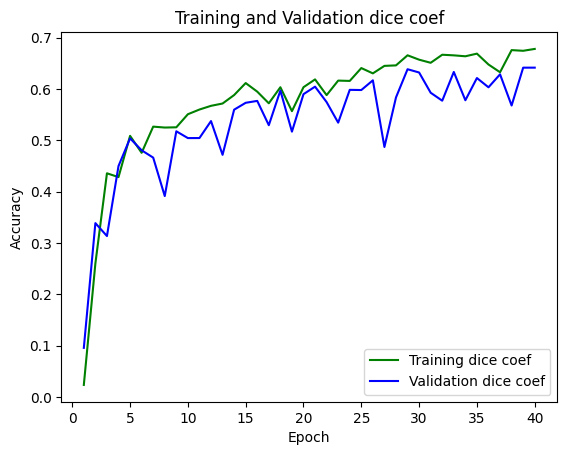

In [ ]:
uNet_tall = UNet(input_size=(tileSize,tileSize,3))

callbacks = [ EarlyStopping(patience=200, monitor="val_dice_coef"),
                 ModelCheckpoint(os.path.join("Output/unet_tall", "unet_tall.hdf5"),
                 monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max') ]

train_rgb_tall = TrainGenerator(8, images_rgb, tall_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTest], [n.reshape(1,tileSize,tileSize,1) for n in yTestTall]))

uNet_tall = train(uNet_tall, callbacks, train_rgb_tall, validation_df, "unet_tall", epochs=40, steps_per_epoch=100)

In [ ]:
save_to_drive()

cp: cannot create directory 'MyDrive/sv_para/': No such file or directory


### **Attention UNet**

Epoch 1/500
100/100 [==============================] - ETA: 0s - loss: 0.1645 - dice_coef: 0.0184 - accuracy: 0.9712 - mse: 0.0315
Epoch 1: val_dice_coef improved from -inf to 0.02212, saving model to Output/unetAM_tall/unetAM_tall.hdf5
100/100 [==============================] - 24s 161ms/step - loss: 0.1645 - dice_coef: 0.0184 - accuracy: 0.9712 - mse: 0.0315 - val_loss: 0.1183 - val_dice_coef: 0.0221 - val_accuracy: 0.9805 - val_mse: 0.0217
Epoch 2/500
100/100 [==============================] - ETA: 0s - loss: 0.1158 - dice_coef: 0.0169 - accuracy: 0.9757 - mse: 0.0217
Epoch 2: val_dice_coef did not improve from 0.02212
100/100 [==============================] - 12s 124ms/step - loss: 0.1158 - dice_coef: 0.0169 - accuracy: 0.9757 - mse: 0.0217 - val_loss: 0.1029 - val_dice_coef: 0.0116 - val_accuracy: 0.9805 - val_mse: 0.0193
Epoch 3/500
100/100 [==============================] - ETA: 0s - loss: 0.1175 - dice_coef: 0.0257 - accuracy: 0.9740 - mse: 0.0227
Epoch 3: val_dice_coef improv

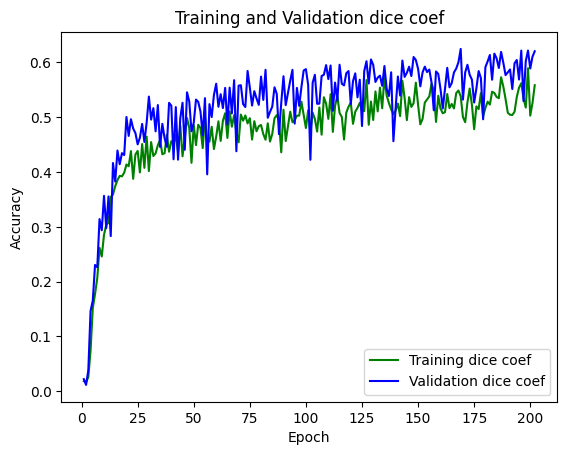

In [ ]:
uNetAM_tall = UNetAM(input_size=(tileSize,tileSize,3), batch_size=1)
# model_amu_tall = load_model('Output/unetAM_tall/unetAM_tall.hdf5', custom_objects={'dice_coef': dice_coef})


callbacks = [ EarlyStopping(patience=200, monitor="val_dice_coef"),
                 ModelCheckpoint(os.path.join("Output/unetAM_tall", "unetAM_tall"+".hdf5"),
                 monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max') ]

train_rgb_tall = TrainGenerator(1, images_rgb, tall_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTest], [n.reshape(1,tileSize,tileSize,1) for n in yTestTall]))

uNetAM_tall = train(uNetAM_tall, callbacks, train_rgb_tall, validation_df, "unetAM_tall", batch_size=1, epochs=500, steps_per_epoch=100)

### **ResNet50SegNet**

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.1465 - dice_coef: 0.0185 - accuracy: 0.9731 - mse: 0.0254
Epoch 1: val_dice_coef improved from -inf to 0.01829, saving model to Output/resNet_tall/resNet.hdf5
100/100 [==============================] - 220s 2s/step - loss: 0.1465 - dice_coef: 0.0185 - accuracy: 0.9731 - mse: 0.0254 - val_loss: 0.1021 - val_dice_coef: 0.0183 - val_accuracy: 0.9796 - val_mse: 0.0202
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.1277 - dice_coef: 0.0212 - accuracy: 0.9756 - mse: 0.0227
Epoch 2: val_dice_coef improved from 0.01829 to 0.02423, saving model to Output/resNet_tall/resNet.hdf5
100/100 [==============================] - 181s 2s/step - loss: 0.1277 - dice_coef: 0.0212 - accuracy: 0.9756 - mse: 0.0227 - val_loss: 0.1081 - val_dice_coef: 0.0242 - val_accuracy: 0.9796 - val_mse: 0.0207
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.1020 - dice_coef: 0.0441 - accuracy: 0.9757 - m

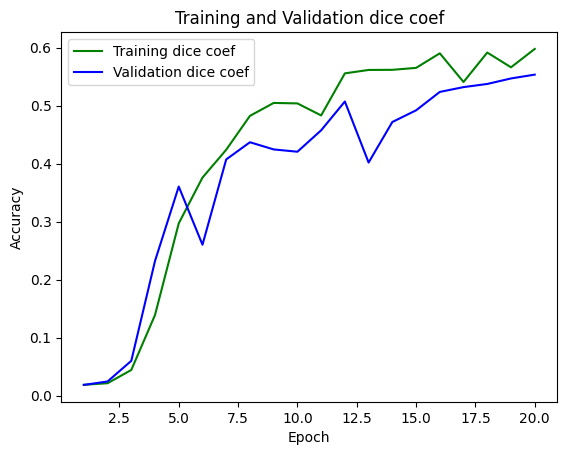

In [ ]:

resNet_tall = ResNet50SegNet(input_size=(tileSize,tileSize,3), lr=0.0001)
# res50 = ResNet50SegNet(input_size=(tileSize,tileSize,3), lr=0.0001)
# res50.load_weights('Output/resNet_tall/resNet.hdf5')

callbacks = [ModelCheckpoint(os.path.join("Output/resNet_tall", "resNet.hdf5"), monitor='val_dice_coef', save_weights_only=True, mode='max', verbose=1, save_best_only=True)]
# callbacks = []
train_rgb_tall = TrainGenerator(4, images_rgb, tall_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTest], [n.reshape(1,tileSize,tileSize,1) for n in yTestTall]))

resNet_tall = train(resNet_tall, callbacks, train_rgb_tall, validation_df, "resNet_tall", epochs=20, steps_per_epoch=100)

### **FCN32-VGG16**

Epoch 1/60
100/100 [==============================] - ETA: 0s - loss: 0.4048 - dice_coef: 0.0358 - accuracy: 0.8626 - mse: 0.1241
Epoch 1: val_dice_coef improved from -inf to 0.02368, saving model to Output/fcn32_tall/fcn32_tall.hdf5
100/100 [==============================] - 97s 850ms/step - loss: 0.4048 - dice_coef: 0.0358 - accuracy: 0.8626 - mse: 0.1241 - val_loss: 0.1212 - val_dice_coef: 0.0237 - val_accuracy: 0.9759 - val_mse: 0.0248
Epoch 2/60
100/100 [==============================] - ETA: 0s - loss: 0.1197 - dice_coef: 0.0233 - accuracy: 0.9744 - mse: 0.0230
Epoch 2: val_dice_coef improved from 0.02368 to 0.02370, saving model to Output/fcn32_tall/fcn32_tall.hdf5
100/100 [==============================] - 92s 921ms/step - loss: 0.1197 - dice_coef: 0.0233 - accuracy: 0.9744 - mse: 0.0230 - val_loss: 0.1149 - val_dice_coef: 0.0237 - val_accuracy: 0.9795 - val_mse: 0.0220
Epoch 3/60
100/100 [==============================] - ETA: 0s - loss: 0.1150 - dice_coef: 0.0215 - accuracy: 

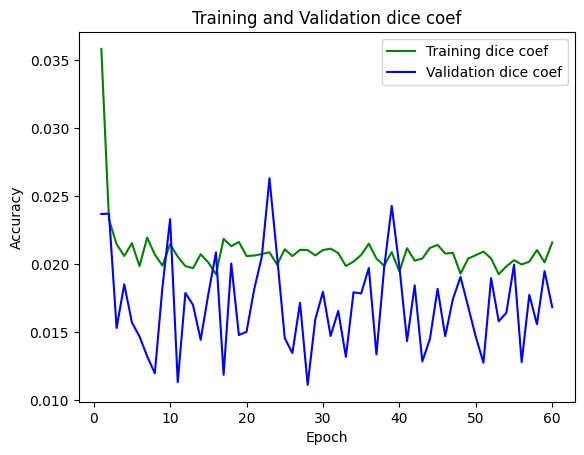

In [ ]:
# Train FCN32 with generator
fcn32_tall = fcn_32(input_size=(tileSize,tileSize,3), lr=0.0005)
#fcn_tall = load_model('Output/fcn32_tall/fcn32_tall.hdf5', custom_objects={'dice_coef': dice_coef})

callbacks = [ModelCheckpoint(os.path.join("Output/fcn32_tall", "fcn32_tall"+".hdf5"),
                             monitor='val_dice_coef',verbose=1, save_best_only=True, mode='max')]
train_rgb_tall = TrainGenerator(4, images_rgb, tall_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTest], [n.reshape(1,tileSize,tileSize,1) for n in yTestTall]))

fcn32_tall = train(fcn32_tall, callbacks, train_rgb_tall, validation_df, "fcn32_tall", epochs=60, steps_per_epoch=100)



### **ResUNet**

In [ ]:
# Train ResUNet with generator
resUNet_tall = res_unet(tileSize, [32, 64, 128, 256], 3, 3, 1)
# resUNet = load_model('Output/resUNet_tall/resUNet_tall.hdf5', custom_objects={'dice_coef': dice_coef})

callbacks = [ModelCheckpoint(os.path.join("Output/resUNet_tall", "resUNet_tall"+".hdf5"),
                             monitor='val_dice_coef',verbose=1, save_best_only=True, mode='max')]
train_rgb_tall = TrainGenerator(8, images_rgb, tall_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTest], [n.reshape(1,tileSize,tileSize,1) for n in yTestTall]))

resUNet_tall = train(resUNet_tall, callbacks, train_rgb_tall, validation_df, "resUNet_tall", epochs=50, steps_per_epoch=100)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.1488 - dice_coef: 0.2433 - accuracy: 0.9520 - mse: 0.0377
Epoch 1: val_dice_coef improved from -inf to 0.09832, saving model to Output/resUNet_tall/resUNet_tall.hdf5
100/100 [==============================] - 139s 1s/step - loss: 0.1488 - dice_coef: 0.2433 - accuracy: 0.9520 - mse: 0.0377 - val_loss: 0.0735 - val_dice_coef: 0.0983 - val_accuracy: 0.9803 - val_mse: 0.0167
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.0467 - dice_coef: 0.4317 - accuracy: 0.9826 - mse: 0.0108
Epoch 2: val_dice_coef did not improve from 0.09832
100/100 [==============================] - 109s 1s/step - loss: 0.0467 - dice_coef: 0.4317 - accuracy: 0.9826 - mse: 0.0108 - val_loss: 0.0972 - val_dice_coef: 0.0230 - val_accuracy: 0.9796 - val_mse: 0.0198
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.0413 - dice_coef: 0.4990 - accuracy: 0.9828 - mse: 0.0104
Epoch 3: val_dice_coef did not imp

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-0bcedec9d5c0>", line 10, in <cell line: 10>
    resUNet_tall = train(resUNet_tall, callbacks, train_rgb_tall, validation_df, "resUNet_tall", epochs=50, steps_per_epoch=100)
  File "<ipython-input-22-324a31e325bb>", line 23, in train
    np.savetxt(fullOutPath+"/%s_Loss.csv" % (modelName),
  File "<__array_function__ internals>", line 180, in savetxt
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 1383, in savetxt
    open(fname, 'wt').close()
OSError: [Errno 107] Transport endpoint is not connected: 'Output/resUNet_tall/resUNet_tall_Loss.csv'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in sh

### **Attention ResUNet**


Epoch 1/60
100/100 [==============================] - ETA: 0s - loss: 0.1314 - dice_coef: 0.4515 - accuracy: 0.9494 - mse: 0.0335
Epoch 1: val_dice_coef improved from -inf to 0.02065, saving model to Output/resaunet_tall_512x512/resaunet_tall_512x512.hdf5
100/100 [==============================] - 75s 499ms/step - loss: 0.1314 - dice_coef: 0.4515 - accuracy: 0.9494 - mse: 0.0335 - val_loss: 1.9700 - val_dice_coef: 0.0207 - val_accuracy: 0.9528 - val_mse: 0.0467
Epoch 2/60
100/100 [==============================] - ETA: 0s - loss: 0.0892 - dice_coef: 0.4886 - accuracy: 0.9619 - mse: 0.0235
Epoch 2: val_dice_coef improved from 0.02065 to 0.09833, saving model to Output/resaunet_tall_512x512/resaunet_tall_512x512.hdf5
100/100 [==============================] - 59s 589ms/step - loss: 0.0892 - dice_coef: 0.4886 - accuracy: 0.9619 - mse: 0.0235 - val_loss: 0.2020 - val_dice_coef: 0.0983 - val_accuracy: 0.9526 - val_mse: 0.0425
Epoch 3/60
100/100 [==============================] - ETA: 0s - l

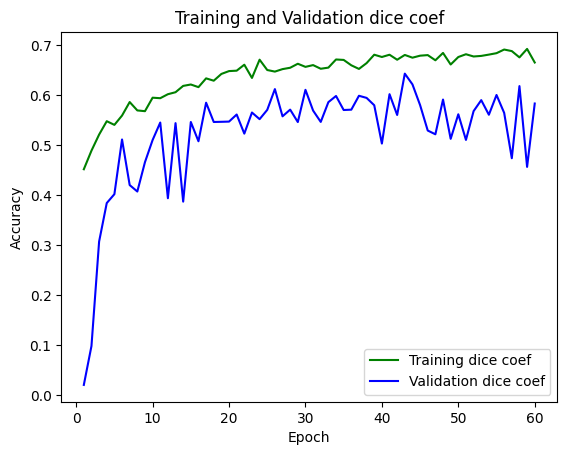

In [ ]:
# Train Res Attention UNet with generator        内存不足改为tilesize 128
# resaunet_tall_ = att_res_unet(tileSize, [64, 128, 256, 512], 3, 3, 1, lr = 0.0005)
#aresUNet = load_model('Output/resaunet_tall_512x512/resaunet_tall_512x512.hdf5', custom_objects={'dice_coef': dice_coef})
aresUNet =  att_res_unet(tileSize, [64, 128, 256, 512], 3, 3, 1, lr = 0.0005)

callbacks = [ModelCheckpoint(os.path.join("Output/resaunet_tall_512x512", "resaunet_tall_512x512"+".hdf5"),
                             monitor='val_dice_coef',verbose=1, save_best_only=True, mode='max')]

train_rgb_tall = TrainGenerator(16, images_rgb, tall_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTest], [n.reshape(1,tileSize,tileSize,1) for n in yTestTall]))

resaunet_tall = train(aresUNet, callbacks, train_rgb_tall, validation_df, "resaunet_tall_512x512", epochs=60, steps_per_epoch=100)

### **UNet++**

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.1999 - dice_coef: 0.0192 - accuracy: 0.9665 - mse: 0.0482
Epoch 1: val_dice_coef improved from -inf to 0.01059, saving model to Output/unet_plus_tall/unet_plus_tall.hdf5
100/100 [==============================] - 188s 2s/step - loss: 0.1999 - dice_coef: 0.0192 - accuracy: 0.9665 - mse: 0.0482 - val_loss: 0.1204 - val_dice_coef: 0.0106 - val_accuracy: 0.9769 - val_mse: 0.0228
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.1036 - dice_coef: 0.0289 - accuracy: 0.9763 - mse: 0.0204
Epoch 2: val_dice_coef improved from 0.01059 to 0.05068, saving model to Output/unet_plus_tall/unet_plus_tall.hdf5
100/100 [==============================] - 151s 2s/step - loss: 0.1036 - dice_coef: 0.0289 - accuracy: 0.9763 - mse: 0.0204 - val_loss: 0.0969 - val_dice_coef: 0.0507 - val_accuracy: 0.9769 - val_mse: 0.0222
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0762 - dice_coef: 0.1300 

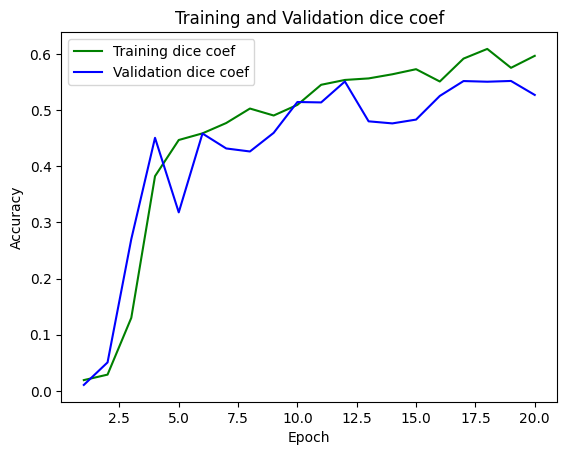

In [ ]:
# Train ResUNet with generator
uNetplus_tall = unet_plus([64, 128, 256, 512], 1, input_size=(tileSize,tileSize,3))
# uNetplus_tall = load_model('Output/unet_plus_tall/unet_plus_tall.hdf5', custom_objects={'dice_coef': dice_coef})

callbacks = [ModelCheckpoint(os.path.join("Output/unet_plus_tall", "unet_plus_tall"+".hdf5"),
                             monitor='val_dice_coef',verbose=1, save_best_only=True, mode='max')]
train_rgb_tall = TrainGenerator(8, images_rgb, tall_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTest], [n.reshape(1,tileSize,tileSize,1) for n in yTestTall]))

uNetplus_tall = train(uNetplus_tall, callbacks, train_rgb_tall, validation_df, "unet_plus_tall", epochs=20, steps_per_epoch=100)
# Total 70 epochs total

### **R2 U-Net**

Epoch 1/15
100/100 [==============================] - ETA: 0s - loss: 0.1319 - dice_coef: 0.0116 - accuracy: 0.9773 - mse: 0.0220
Epoch 1: val_dice_coef improved from -inf to 0.01044, saving model to Output/r2_unet_tall_256/r2_unet_tall_256.hdf5
100/100 [==============================] - 70s 662ms/step - loss: 0.1319 - dice_coef: 0.0116 - accuracy: 0.9773 - mse: 0.0220 - val_loss: 0.1241 - val_dice_coef: 0.0104 - val_accuracy: 0.9769 - val_mse: 0.0229
Epoch 2/15
100/100 [==============================] - ETA: 0s - loss: 0.1085 - dice_coef: 0.0197 - accuracy: 0.9780 - mse: 0.0197
Epoch 2: val_dice_coef improved from 0.01044 to 0.04224, saving model to Output/r2_unet_tall_256/r2_unet_tall_256.hdf5
100/100 [==============================] - 71s 713ms/step - loss: 0.1085 - dice_coef: 0.0197 - accuracy: 0.9780 - mse: 0.0197 - val_loss: 0.1029 - val_dice_coef: 0.0422 - val_accuracy: 0.9769 - val_mse: 0.0221
Epoch 3/15
100/100 [==============================] - ETA: 0s - loss: 0.1029 - dice_c

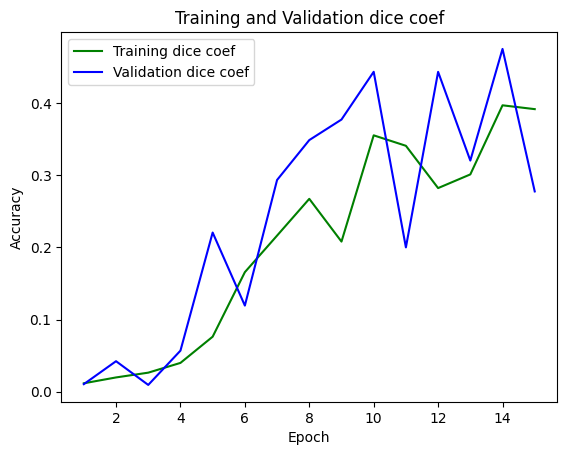

In [ ]:
# Train ResUNet with generator
r2_unet_tall = r2_unet([64, 128, 256, 512], 1, input_size=(tileSize,tileSize,3))
#r2_unet = load_model('Output/r2_unet_tall_256/r2_unet_tall_256.hdf5', custom_objects={'dice_coef': dice_coef})

callbacks = [ModelCheckpoint(os.path.join("Output/r2_unet_tall_256", "r2_unet_tall_256"+".hdf5"),
                             monitor='val_dice_coef',verbose=1, save_best_only=True, mode='max')]
train_rgb_tall = TrainGenerator(1, images_rgb, tall_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTest], [n.reshape(1,tileSize,tileSize,1) for n in yTestTall]))

# Trained for 100 epochs total
r2_unet_tall = train(r2_unet_tall, callbacks, train_rgb_tall, validation_df, "r2_unet_tall_256", epochs=100, steps_per_epoch=100)

In [ ]:
#new train without curve
from tensorflow.keras.callbacks import EarlyStopping
import time
def train(model, callbacks, inGen, valGen, modelName, batch_size=1, epochs=20, steps_per_epoch=100):
    fullOutPath = os.path.join("Output", modelName)
    if not os.path.exists(fullOutPath):
        os.mkdir(fullOutPath)

    startTime = time.time()
    history = model.fit(
        inGen,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=valGen,
        batch_size=batch_size,
        callbacks=[callbacks]
    )
    trainTime = time.time() - startTime
    print("Total time to train:", trainTime)

    # Saving to drive
    save_to_drive()

    # Rest of the code...
    return model

### **U^2 Net**

In [ ]:
# Train ResUNet with generator
# def u2net(n_labels, filter_num_down, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, num_out=1, out_layer = 'Sigmoid', lossfunc = 'binary_crossentropy'):

u2net_tall = u2net(2, [32, 64, 128, 256], input_size=(tileSize, tileSize, 3))
# u2net_tall = load_model('Output/u2net_tall/u2net_tall.hdf5', custom_objects={'dice_coef': dice_coef})

callbacks = [ModelCheckpoint(os.path.join("Output/u2net_tall", "u2net_tall"+".hdf5"),
                             monitor='val_dice_coef',verbose=1, save_best_only=True)]


train_rgb_tall = TrainGenerator(4, images_rgb, tall_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTest], [n.reshape(1,tileSize,tileSize,1) for n in yTestTall]))

u2net_tall = train(u2net_tall, callbacks, train_rgb_tall, validation_df, "u2net_tall", epochs=50, steps_per_epoch=100)
# Total 70 epochs total

----------
The depth of u2net_2d = len(filter_num_down) + len(filter_4f_num) = 6
----------
deep_supervision = True
names of output tensors are listed as follows ("sup0" is the shallowest supervision layer;
"final" is the final output layer):

	u2net_output_sup0_activation
	u2net_output_sup1_activation
	u2net_output_sup2_activation
	u2net_output_sup3_activation
	u2net_output_sup4_activation
	u2net_output_sup5_activation
	u2net_output_final_activation
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 4.4798 - u2net_output_sup0_activation_loss: 0.1472 - u2net_output_sup1_activation_loss: 0.5327 - u2net_output_sup2_activation_loss: 0.6856 - u2net_output_sup3_activation_loss: 0.6848 - u2net_output_sup4_activation_loss: 0.6849 - u2net_output_sup5_activation_loss: 0.6908 - u2net_output_final_activation_loss: 1.0539 - u2net_output_sup0_activation_dice_coef: 0.1365 - u2net_output_sup0_activation_accuracy: 0.9685 - u2net_output_sup0_activation_mse: 0.0317 - u2net_output_sup1

100/100 [==============================] - 166s 1s/step - loss: 4.4798 - u2net_output_sup0_activation_loss: 0.1472 - u2net_output_sup1_activation_loss: 0.5327 - u2net_output_sup2_activation_loss: 0.6856 - u2net_output_sup3_activation_loss: 0.6848 - u2net_output_sup4_activation_loss: 0.6849 - u2net_output_sup5_activation_loss: 0.6908 - u2net_output_final_activation_loss: 1.0539 - u2net_output_sup0_activation_dice_coef: 0.1365 - u2net_output_sup0_activation_accuracy: 0.9685 - u2net_output_sup0_activation_mse: 0.0317 - u2net_output_sup1_activation_dice_coef: 0.0506 - u2net_output_sup1_activation_accuracy: 0.8340 - u2net_output_sup1_activation_mse: 0.1796 - u2net_output_sup2_activation_dice_coef: 0.0420 - u2net_output_sup2_activation_accuracy: 0.7351 - u2net_output_sup2_activation_mse: 0.2446 - u2net_output_sup3_activation_dice_coef: 0.0418 - u2net_output_sup3_activation_accuracy: 0.9187 - u2net_output_sup3_activation_mse: 0.2453 - u2net_output_sup4_activation_dice_coef: 0.0417 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 4.1974 - u2net_output_sup0_activation_loss: 0.0637 - u2net_output_sup1_activation_loss: 0.3739 - u2net_output_sup2_activation_loss: 0.6751 - u2net_output_sup3_activation_loss: 0.6779 - u2net_output_sup4_activation_loss: 0.6789 - u2net_output_sup5_activation_loss: 0.6860 - u2net_output_final_activation_loss: 1.0418 - u2net_output_sup0_activation_dice_coef: 0.2431 - u2net_output_sup0_activation_accuracy: 0.9799 - u2net_output_sup0_activation_mse: 0.0135 - u2net_output_sup1_activation_dice_coef: 0.0581 - u2net_output_sup1_activation_accuracy: 0.9694 - u2net_output_sup1_activation_mse: 0.1143 - u2net_output_sup2_activation_dice_coef: 0.0396 - u2net_output_sup2_activation_accuracy: 0.7380 - u2net_output_sup2_activation_mse: 0.2395 - u2net_output_sup3_activation_dice_coef: 0.0392 - u2net_output_sup3_activation_accuracy: 0.9324 - u2net_output_sup3_activation_mse: 0.2422 - u2net_output_sup4_activation_dice_coef: 0.0391 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 4.0542 - u2net_output_sup0_activation_loss: 0.0538 - u2net_output_sup1_activation_loss: 0.2781 - u2net_output_sup2_activation_loss: 0.6656 - u2net_output_sup3_activation_loss: 0.6717 - u2net_output_sup4_activation_loss: 0.6737 - u2net_output_sup5_activation_loss: 0.6812 - u2net_output_final_activation_loss: 1.0301 - u2net_output_sup0_activation_dice_coef: 0.3070 - u2net_output_sup0_activation_accuracy: 0.9808 - u2net_output_sup0_activation_mse: 0.0124 - u2net_output_sup1_activation_dice_coef: 0.0726 - u2net_output_sup1_activation_accuracy: 0.9775 - u2net_output_sup1_activation_mse: 0.0756 - u2net_output_sup2_activation_dice_coef: 0.0398 - u2net_output_sup2_activation_accuracy: 0.7380 - u2net_output_sup2_activation_mse: 0.2347 - u2net_output_sup3_activation_dice_coef: 0.0392 - u2net_output_sup3_activation_accuracy: 0.9323 - u2net_output_sup3_activation_mse: 0.2392 - u2net_output_sup4_activation_dice_coef: 0.0390 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 3.9458 - u2net_output_sup0_activation_loss: 0.0531 - u2net_output_sup1_activation_loss: 0.2096 - u2net_output_sup2_activation_loss: 0.6558 - u2net_output_sup3_activation_loss: 0.6656 - u2net_output_sup4_activation_loss: 0.6687 - u2net_output_sup5_activation_loss: 0.6765 - u2net_output_final_activation_loss: 1.0167 - u2net_output_sup0_activation_dice_coef: 0.3373 - u2net_output_sup0_activation_accuracy: 0.9795 - u2net_output_sup0_activation_mse: 0.0131 - u2net_output_sup1_activation_dice_coef: 0.0970 - u2net_output_sup1_activation_accuracy: 0.9772 - u2net_output_sup1_activation_mse: 0.0513 - u2net_output_sup2_activation_dice_coef: 0.0423 - u2net_output_sup2_activation_accuracy: 0.7377 - u2net_output_sup2_activation_mse: 0.2298 - u2net_output_sup3_activation_dice_coef: 0.0414 - u2net_output_sup3_activation_accuracy: 0.9313 - u2net_output_sup3_activation_mse: 0.2364 - u2net_output_sup4_activation_dice_coef: 0.0410 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 3.8489 - u2net_output_sup0_activation_loss: 0.0479 - u2net_output_sup1_activation_loss: 0.1589 - u2net_output_sup2_activation_loss: 0.6451 - u2net_output_sup3_activation_loss: 0.6593 - u2net_output_sup4_activation_loss: 0.6635 - u2net_output_sup5_activation_loss: 0.6717 - u2net_output_final_activation_loss: 1.0025 - u2net_output_sup0_activation_dice_coef: 0.3481 - u2net_output_sup0_activation_accuracy: 0.9810 - u2net_output_sup0_activation_mse: 0.0120 - u2net_output_sup1_activation_dice_coef: 0.1150 - u2net_output_sup1_activation_accuracy: 0.9796 - u2net_output_sup1_activation_mse: 0.0352 - u2net_output_sup2_activation_dice_coef: 0.0401 - u2net_output_sup2_activation_accuracy: 0.7389 - u2net_output_sup2_activation_mse: 0.2246 - u2net_output_sup3_activation_dice_coef: 0.0389 - u2net_output_sup3_activation_accuracy: 0.9324 - u2net_output_sup3_activation_mse: 0.2335 - u2net_output_sup4_activation_dice_coef: 0.0385 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 3.7755 - u2net_output_sup0_activation_loss: 0.0478 - u2net_output_sup1_activation_loss: 0.1284 - u2net_output_sup2_activation_loss: 0.6345 - u2net_output_sup3_activation_loss: 0.6533 - u2net_output_sup4_activation_loss: 0.6585 - u2net_output_sup5_activation_loss: 0.6671 - u2net_output_final_activation_loss: 0.9858 - u2net_output_sup0_activation_dice_coef: 0.3793 - u2net_output_sup0_activation_accuracy: 0.9807 - u2net_output_sup0_activation_mse: 0.0122 - u2net_output_sup1_activation_dice_coef: 0.1502 - u2net_output_sup1_activation_accuracy: 0.9794 - u2net_output_sup1_activation_mse: 0.0267 - u2net_output_sup2_activation_dice_coef: 0.0439 - u2net_output_sup2_activation_accuracy: 0.7623 - u2net_output_sup2_activation_mse: 0.2195 - u2net_output_sup3_activation_dice_coef: 0.0424 - u2net_output_sup3_activation_accuracy: 0.9316 - u2net_output_sup3_activation_mse: 0.2307 - u2net_output_sup4_activation_dice_coef: 0.0419 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 3.7041 - u2net_output_sup0_activation_loss: 0.0444 - u2net_output_sup1_activation_loss: 0.1044 - u2net_output_sup2_activation_loss: 0.6232 - u2net_output_sup3_activation_loss: 0.6471 - u2net_output_sup4_activation_loss: 0.6535 - u2net_output_sup5_activation_loss: 0.6624 - u2net_output_final_activation_loss: 0.9690 - u2net_output_sup0_activation_dice_coef: 0.3950 - u2net_output_sup0_activation_accuracy: 0.9819 - u2net_output_sup0_activation_mse: 0.0113 - u2net_output_sup1_activation_dice_coef: 0.1766 - u2net_output_sup1_activation_accuracy: 0.9807 - u2net_output_sup1_activation_mse: 0.0207 - u2net_output_sup2_activation_dice_coef: 0.0418 - u2net_output_sup2_activation_accuracy: 0.8478 - u2net_output_sup2_activation_mse: 0.2142 - u2net_output_sup3_activation_dice_coef: 0.0397 - u2net_output_sup3_activation_accuracy: 0.9323 - u2net_output_sup3_activation_mse: 0.2278 - u2net_output_sup4_activation_dice_coef: 0.0391 - u2net_out

100/100 [==============================] - 106s 1s/step - loss: 3.6425 - u2net_output_sup0_activation_loss: 0.0428 - u2net_output_sup1_activation_loss: 0.0893 - u2net_output_sup2_activation_loss: 0.6118 - u2net_output_sup3_activation_loss: 0.6409 - u2net_output_sup4_activation_loss: 0.6485 - u2net_output_sup5_activation_loss: 0.6578 - u2net_output_final_activation_loss: 0.9514 - u2net_output_sup0_activation_dice_coef: 0.4248 - u2net_output_sup0_activation_accuracy: 0.9828 - u2net_output_sup0_activation_mse: 0.0108 - u2net_output_sup1_activation_dice_coef: 0.2077 - u2net_output_sup1_activation_accuracy: 0.9818 - u2net_output_sup1_activation_mse: 0.0171 - u2net_output_sup2_activation_dice_coef: 0.0424 - u2net_output_sup2_activation_accuracy: 0.8584 - u2net_output_sup2_activation_mse: 0.2090 - u2net_output_sup3_activation_dice_coef: 0.0398 - u2net_output_sup3_activation_accuracy: 0.9324 - u2net_output_sup3_activation_mse: 0.2250 - u2net_output_sup4_activation_dice_coef: 0.0392 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 3.5870 - u2net_output_sup0_activation_loss: 0.0421 - u2net_output_sup1_activation_loss: 0.0791 - u2net_output_sup2_activation_loss: 0.6004 - u2net_output_sup3_activation_loss: 0.6349 - u2net_output_sup4_activation_loss: 0.6436 - u2net_output_sup5_activation_loss: 0.6533 - u2net_output_final_activation_loss: 0.9336 - u2net_output_sup0_activation_dice_coef: 0.4423 - u2net_output_sup0_activation_accuracy: 0.9829 - u2net_output_sup0_activation_mse: 0.0107 - u2net_output_sup1_activation_dice_coef: 0.2405 - u2net_output_sup1_activation_accuracy: 0.9818 - u2net_output_sup1_activation_mse: 0.0152 - u2net_output_sup2_activation_dice_coef: 0.0434 - u2net_output_sup2_activation_accuracy: 0.8589 - u2net_output_sup2_activation_mse: 0.2040 - u2net_output_sup3_activation_dice_coef: 0.0403 - u2net_output_sup3_activation_accuracy: 0.9322 - u2net_output_sup3_activation_mse: 0.2222 - u2net_output_sup4_activation_dice_coef: 0.0395 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 3.5335 - u2net_output_sup0_activation_loss: 0.0410 - u2net_output_sup1_activation_loss: 0.0713 - u2net_output_sup2_activation_loss: 0.5890 - u2net_output_sup3_activation_loss: 0.6290 - u2net_output_sup4_activation_loss: 0.6390 - u2net_output_sup5_activation_loss: 0.6489 - u2net_output_final_activation_loss: 0.9154 - u2net_output_sup0_activation_dice_coef: 0.4793 - u2net_output_sup0_activation_accuracy: 0.9827 - u2net_output_sup0_activation_mse: 0.0105 - u2net_output_sup1_activation_dice_coef: 0.2879 - u2net_output_sup1_activation_accuracy: 0.9815 - u2net_output_sup1_activation_mse: 0.0142 - u2net_output_sup2_activation_dice_coef: 0.0485 - u2net_output_sup2_activation_accuracy: 0.8792 - u2net_output_sup2_activation_mse: 0.1991 - u2net_output_sup3_activation_dice_coef: 0.0440 - u2net_output_sup3_activation_accuracy: 0.9308 - u2net_output_sup3_activation_mse: 0.2195 - u2net_output_sup4_activation_dice_coef: 0.0431 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 3.4798 - u2net_output_sup0_activation_loss: 0.0388 - u2net_output_sup1_activation_loss: 0.0643 - u2net_output_sup2_activation_loss: 0.5773 - u2net_output_sup3_activation_loss: 0.6227 - u2net_output_sup4_activation_loss: 0.6340 - u2net_output_sup5_activation_loss: 0.6443 - u2net_output_final_activation_loss: 0.8985 - u2net_output_sup0_activation_dice_coef: 0.4798 - u2net_output_sup0_activation_accuracy: 0.9838 - u2net_output_sup0_activation_mse: 0.0099 - u2net_output_sup1_activation_dice_coef: 0.3002 - u2net_output_sup1_activation_accuracy: 0.9826 - u2net_output_sup1_activation_mse: 0.0128 - u2net_output_sup2_activation_dice_coef: 0.0461 - u2net_output_sup2_activation_accuracy: 0.9185 - u2net_output_sup2_activation_mse: 0.1941 - u2net_output_sup3_activation_dice_coef: 0.0415 - u2net_output_sup3_activation_accuracy: 0.9324 - u2net_output_sup3_activation_mse: 0.2167 - u2net_output_sup4_activation_dice_coef: 0.0404 - u2net_out

100/100 [==============================] - 106s 1s/step - loss: 3.4357 - u2net_output_sup0_activation_loss: 0.0407 - u2net_output_sup1_activation_loss: 0.0619 - u2net_output_sup2_activation_loss: 0.5661 - u2net_output_sup3_activation_loss: 0.6169 - u2net_output_sup4_activation_loss: 0.6293 - u2net_output_sup5_activation_loss: 0.6399 - u2net_output_final_activation_loss: 0.8809 - u2net_output_sup0_activation_dice_coef: 0.4678 - u2net_output_sup0_activation_accuracy: 0.9830 - u2net_output_sup0_activation_mse: 0.0104 - u2net_output_sup1_activation_dice_coef: 0.3174 - u2net_output_sup1_activation_accuracy: 0.9821 - u2net_output_sup1_activation_mse: 0.0129 - u2net_output_sup2_activation_dice_coef: 0.0484 - u2net_output_sup2_activation_accuracy: 0.9178 - u2net_output_sup2_activation_mse: 0.1895 - u2net_output_sup3_activation_dice_coef: 0.0429 - u2net_output_sup3_activation_accuracy: 0.9337 - u2net_output_sup3_activation_mse: 0.2140 - u2net_output_sup4_activation_dice_coef: 0.0418 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 3.3825 - u2net_output_sup0_activation_loss: 0.0370 - u2net_output_sup1_activation_loss: 0.0558 - u2net_output_sup2_activation_loss: 0.5546 - u2net_output_sup3_activation_loss: 0.6107 - u2net_output_sup4_activation_loss: 0.6243 - u2net_output_sup5_activation_loss: 0.6354 - u2net_output_final_activation_loss: 0.8647 - u2net_output_sup0_activation_dice_coef: 0.4929 - u2net_output_sup0_activation_accuracy: 0.9843 - u2net_output_sup0_activation_mse: 0.0096 - u2net_output_sup1_activation_dice_coef: 0.3383 - u2net_output_sup1_activation_accuracy: 0.9831 - u2net_output_sup1_activation_mse: 0.0118 - u2net_output_sup2_activation_dice_coef: 0.0470 - u2net_output_sup2_activation_accuracy: 0.9190 - u2net_output_sup2_activation_mse: 0.1849 - u2net_output_sup3_activation_dice_coef: 0.0411 - u2net_output_sup3_activation_accuracy: 0.9570 - u2net_output_sup3_activation_mse: 0.2113 - u2net_output_sup4_activation_dice_coef: 0.0399 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 3.3374 - u2net_output_sup0_activation_loss: 0.0368 - u2net_output_sup1_activation_loss: 0.0535 - u2net_output_sup2_activation_loss: 0.5435 - u2net_output_sup3_activation_loss: 0.6048 - u2net_output_sup4_activation_loss: 0.6196 - u2net_output_sup5_activation_loss: 0.6310 - u2net_output_final_activation_loss: 0.8482 - u2net_output_sup0_activation_dice_coef: 0.4950 - u2net_output_sup0_activation_accuracy: 0.9841 - u2net_output_sup0_activation_mse: 0.0096 - u2net_output_sup1_activation_dice_coef: 0.3524 - u2net_output_sup1_activation_accuracy: 0.9831 - u2net_output_sup1_activation_mse: 0.0116 - u2net_output_sup2_activation_dice_coef: 0.0481 - u2net_output_sup2_activation_accuracy: 0.9188 - u2net_output_sup2_activation_mse: 0.1805 - u2net_output_sup3_activation_dice_coef: 0.0415 - u2net_output_sup3_activation_accuracy: 0.9620 - u2net_output_sup3_activation_mse: 0.2086 - u2net_output_sup4_activation_dice_coef: 0.0403 - u2net_out

100/100 [==============================] - 106s 1s/step - loss: 3.2875 - u2net_output_sup0_activation_loss: 0.0342 - u2net_output_sup1_activation_loss: 0.0490 - u2net_output_sup2_activation_loss: 0.5321 - u2net_output_sup3_activation_loss: 0.5985 - u2net_output_sup4_activation_loss: 0.6146 - u2net_output_sup5_activation_loss: 0.6264 - u2net_output_final_activation_loss: 0.8326 - u2net_output_sup0_activation_dice_coef: 0.5147 - u2net_output_sup0_activation_accuracy: 0.9852 - u2net_output_sup0_activation_mse: 0.0088 - u2net_output_sup1_activation_dice_coef: 0.3767 - u2net_output_sup1_activation_accuracy: 0.9841 - u2net_output_sup1_activation_mse: 0.0107 - u2net_output_sup2_activation_dice_coef: 0.0476 - u2net_output_sup2_activation_accuracy: 0.9201 - u2net_output_sup2_activation_mse: 0.1761 - u2net_output_sup3_activation_dice_coef: 0.0402 - u2net_output_sup3_activation_accuracy: 0.9632 - u2net_output_sup3_activation_mse: 0.2059 - u2net_output_sup4_activation_dice_coef: 0.0388 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 3.2448 - u2net_output_sup0_activation_loss: 0.0344 - u2net_output_sup1_activation_loss: 0.0471 - u2net_output_sup2_activation_loss: 0.5215 - u2net_output_sup3_activation_loss: 0.5927 - u2net_output_sup4_activation_loss: 0.6099 - u2net_output_sup5_activation_loss: 0.6222 - u2net_output_final_activation_loss: 0.8170 - u2net_output_sup0_activation_dice_coef: 0.5122 - u2net_output_sup0_activation_accuracy: 0.9850 - u2net_output_sup0_activation_mse: 0.0089 - u2net_output_sup1_activation_dice_coef: 0.3883 - u2net_output_sup1_activation_accuracy: 0.9842 - u2net_output_sup1_activation_mse: 0.0105 - u2net_output_sup2_activation_dice_coef: 0.0492 - u2net_output_sup2_activation_accuracy: 0.9199 - u2net_output_sup2_activation_mse: 0.1720 - u2net_output_sup3_activation_dice_coef: 0.0412 - u2net_output_sup3_activation_accuracy: 0.9627 - u2net_output_sup3_activation_mse: 0.2033 - u2net_output_sup4_activation_dice_coef: 0.0397 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 3.2145 - u2net_output_sup0_activation_loss: 0.0387 - u2net_output_sup1_activation_loss: 0.0511 - u2net_output_sup2_activation_loss: 0.5121 - u2net_output_sup3_activation_loss: 0.5874 - u2net_output_sup4_activation_loss: 0.6055 - u2net_output_sup5_activation_loss: 0.6182 - u2net_output_final_activation_loss: 0.8015 - u2net_output_sup0_activation_dice_coef: 0.5062 - u2net_output_sup0_activation_accuracy: 0.9833 - u2net_output_sup0_activation_mse: 0.0101 - u2net_output_sup1_activation_dice_coef: 0.3928 - u2net_output_sup1_activation_accuracy: 0.9824 - u2net_output_sup1_activation_mse: 0.0117 - u2net_output_sup2_activation_dice_coef: 0.0534 - u2net_output_sup2_activation_accuracy: 0.9182 - u2net_output_sup2_activation_mse: 0.1685 - u2net_output_sup3_activation_dice_coef: 0.0442 - u2net_output_sup3_activation_accuracy: 0.9608 - u2net_output_sup3_activation_mse: 0.2008 - u2net_output_sup4_activation_dice_coef: 0.0425 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 3.1623 - u2net_output_sup0_activation_loss: 0.0338 - u2net_output_sup1_activation_loss: 0.0449 - u2net_output_sup2_activation_loss: 0.5010 - u2net_output_sup3_activation_loss: 0.5812 - u2net_output_sup4_activation_loss: 0.6004 - u2net_output_sup5_activation_loss: 0.6137 - u2net_output_final_activation_loss: 0.7872 - u2net_output_sup0_activation_dice_coef: 0.5387 - u2net_output_sup0_activation_accuracy: 0.9849 - u2net_output_sup0_activation_mse: 0.0088 - u2net_output_sup1_activation_dice_coef: 0.4230 - u2net_output_sup1_activation_accuracy: 0.9839 - u2net_output_sup1_activation_mse: 0.0103 - u2net_output_sup2_activation_dice_coef: 0.0524 - u2net_output_sup2_activation_accuracy: 0.9195 - u2net_output_sup2_activation_mse: 0.1645 - u2net_output_sup3_activation_dice_coef: 0.0425 - u2net_output_sup3_activation_accuracy: 0.9620 - u2net_output_sup3_activation_mse: 0.1982 - u2net_output_sup4_activation_dice_coef: 0.0407 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 3.1196 - u2net_output_sup0_activation_loss: 0.0326 - u2net_output_sup1_activation_loss: 0.0430 - u2net_output_sup2_activation_loss: 0.4908 - u2net_output_sup3_activation_loss: 0.5753 - u2net_output_sup4_activation_loss: 0.5954 - u2net_output_sup5_activation_loss: 0.6094 - u2net_output_final_activation_loss: 0.7731 - u2net_output_sup0_activation_dice_coef: 0.5335 - u2net_output_sup0_activation_accuracy: 0.9855 - u2net_output_sup0_activation_mse: 0.0085 - u2net_output_sup1_activation_dice_coef: 0.4234 - u2net_output_sup1_activation_accuracy: 0.9844 - u2net_output_sup1_activation_mse: 0.0100 - u2net_output_sup2_activation_dice_coef: 0.0525 - u2net_output_sup2_activation_accuracy: 0.9201 - u2net_output_sup2_activation_mse: 0.1608 - u2net_output_sup3_activation_dice_coef: 0.0419 - u2net_output_sup3_activation_accuracy: 0.9627 - u2net_output_sup3_activation_mse: 0.1956 - u2net_output_sup4_activation_dice_coef: 0.0400 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 3.0862 - u2net_output_sup0_activation_loss: 0.0347 - u2net_output_sup1_activation_loss: 0.0448 - u2net_output_sup2_activation_loss: 0.4816 - u2net_output_sup3_activation_loss: 0.5698 - u2net_output_sup4_activation_loss: 0.5908 - u2net_output_sup5_activation_loss: 0.6053 - u2net_output_final_activation_loss: 0.7592 - u2net_output_sup0_activation_dice_coef: 0.5284 - u2net_output_sup0_activation_accuracy: 0.9848 - u2net_output_sup0_activation_mse: 0.0090 - u2net_output_sup1_activation_dice_coef: 0.4240 - u2net_output_sup1_activation_accuracy: 0.9837 - u2net_output_sup1_activation_mse: 0.0105 - u2net_output_sup2_activation_dice_coef: 0.0538 - u2net_output_sup2_activation_accuracy: 0.9195 - u2net_output_sup2_activation_mse: 0.1575 - u2net_output_sup3_activation_dice_coef: 0.0427 - u2net_output_sup3_activation_accuracy: 0.9621 - u2net_output_sup3_activation_mse: 0.1931 - u2net_output_sup4_activation_dice_coef: 0.0407 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 3.0414 - u2net_output_sup0_activation_loss: 0.0321 - u2net_output_sup1_activation_loss: 0.0412 - u2net_output_sup2_activation_loss: 0.4716 - u2net_output_sup3_activation_loss: 0.5639 - u2net_output_sup4_activation_loss: 0.5859 - u2net_output_sup5_activation_loss: 0.6010 - u2net_output_final_activation_loss: 0.7459 - u2net_output_sup0_activation_dice_coef: 0.5322 - u2net_output_sup0_activation_accuracy: 0.9857 - u2net_output_sup0_activation_mse: 0.0084 - u2net_output_sup1_activation_dice_coef: 0.4306 - u2net_output_sup1_activation_accuracy: 0.9847 - u2net_output_sup1_activation_mse: 0.0097 - u2net_output_sup2_activation_dice_coef: 0.0538 - u2net_output_sup2_activation_accuracy: 0.9204 - u2net_output_sup2_activation_mse: 0.1540 - u2net_output_sup3_activation_dice_coef: 0.0421 - u2net_output_sup3_activation_accuracy: 0.9630 - u2net_output_sup3_activation_mse: 0.1906 - u2net_output_sup4_activation_dice_coef: 0.0400 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 3.0042 - u2net_output_sup0_activation_loss: 0.0324 - u2net_output_sup1_activation_loss: 0.0406 - u2net_output_sup2_activation_loss: 0.4622 - u2net_output_sup3_activation_loss: 0.5582 - u2net_output_sup4_activation_loss: 0.5814 - u2net_output_sup5_activation_loss: 0.5967 - u2net_output_final_activation_loss: 0.7328 - u2net_output_sup0_activation_dice_coef: 0.5286 - u2net_output_sup0_activation_accuracy: 0.9856 - u2net_output_sup0_activation_mse: 0.0085 - u2net_output_sup1_activation_dice_coef: 0.4353 - u2net_output_sup1_activation_accuracy: 0.9848 - u2net_output_sup1_activation_mse: 0.0097 - u2net_output_sup2_activation_dice_coef: 0.0545 - u2net_output_sup2_activation_accuracy: 0.9206 - u2net_output_sup2_activation_mse: 0.1508 - u2net_output_sup3_activation_dice_coef: 0.0421 - u2net_output_sup3_activation_accuracy: 0.9633 - u2net_output_sup3_activation_mse: 0.1882 - u2net_output_sup4_activation_dice_coef: 0.0399 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 2.9704 - u2net_output_sup0_activation_loss: 0.0331 - u2net_output_sup1_activation_loss: 0.0408 - u2net_output_sup2_activation_loss: 0.4534 - u2net_output_sup3_activation_loss: 0.5529 - u2net_output_sup4_activation_loss: 0.5773 - u2net_output_sup5_activation_loss: 0.5928 - u2net_output_final_activation_loss: 0.7201 - u2net_output_sup0_activation_dice_coef: 0.5483 - u2net_output_sup0_activation_accuracy: 0.9854 - u2net_output_sup0_activation_mse: 0.0086 - u2net_output_sup1_activation_dice_coef: 0.4573 - u2net_output_sup1_activation_accuracy: 0.9846 - u2net_output_sup1_activation_mse: 0.0097 - u2net_output_sup2_activation_dice_coef: 0.0561 - u2net_output_sup2_activation_accuracy: 0.9201 - u2net_output_sup2_activation_mse: 0.1478 - u2net_output_sup3_activation_dice_coef: 0.0426 - u2net_output_sup3_activation_accuracy: 0.9625 - u2net_output_sup3_activation_mse: 0.1859 - u2net_output_sup4_activation_dice_coef: 0.0403 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 2.9325 - u2net_output_sup0_activation_loss: 0.0315 - u2net_output_sup1_activation_loss: 0.0391 - u2net_output_sup2_activation_loss: 0.4446 - u2net_output_sup3_activation_loss: 0.5474 - u2net_output_sup4_activation_loss: 0.5733 - u2net_output_sup5_activation_loss: 0.5888 - u2net_output_final_activation_loss: 0.7077 - u2net_output_sup0_activation_dice_coef: 0.5600 - u2net_output_sup0_activation_accuracy: 0.9858 - u2net_output_sup0_activation_mse: 0.0082 - u2net_output_sup1_activation_dice_coef: 0.4706 - u2net_output_sup1_activation_accuracy: 0.9848 - u2net_output_sup1_activation_mse: 0.0094 - u2net_output_sup2_activation_dice_coef: 0.0590 - u2net_output_sup2_activation_accuracy: 0.9200 - u2net_output_sup2_activation_mse: 0.1449 - u2net_output_sup3_activation_dice_coef: 0.0442 - u2net_output_sup3_activation_accuracy: 0.9623 - u2net_output_sup3_activation_mse: 0.1835 - u2net_output_sup4_activation_dice_coef: 0.0415 - u2net_out

100/100 [==============================] - 106s 1s/step - loss: 2.8954 - u2net_output_sup0_activation_loss: 0.0304 - u2net_output_sup1_activation_loss: 0.0377 - u2net_output_sup2_activation_loss: 0.4358 - u2net_output_sup3_activation_loss: 0.5420 - u2net_output_sup4_activation_loss: 0.5692 - u2net_output_sup5_activation_loss: 0.5846 - u2net_output_final_activation_loss: 0.6956 - u2net_output_sup0_activation_dice_coef: 0.5680 - u2net_output_sup0_activation_accuracy: 0.9860 - u2net_output_sup0_activation_mse: 0.0080 - u2net_output_sup1_activation_dice_coef: 0.4812 - u2net_output_sup1_activation_accuracy: 0.9850 - u2net_output_sup1_activation_mse: 0.0092 - u2net_output_sup2_activation_dice_coef: 0.0587 - u2net_output_sup2_activation_accuracy: 0.9203 - u2net_output_sup2_activation_mse: 0.1420 - u2net_output_sup3_activation_dice_coef: 0.0432 - u2net_output_sup3_activation_accuracy: 0.9625 - u2net_output_sup3_activation_mse: 0.1812 - u2net_output_sup4_activation_dice_coef: 0.0405 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 2.8635 - u2net_output_sup0_activation_loss: 0.0312 - u2net_output_sup1_activation_loss: 0.0382 - u2net_output_sup2_activation_loss: 0.4276 - u2net_output_sup3_activation_loss: 0.5366 - u2net_output_sup4_activation_loss: 0.5654 - u2net_output_sup5_activation_loss: 0.5806 - u2net_output_final_activation_loss: 0.6839 - u2net_output_sup0_activation_dice_coef: 0.5646 - u2net_output_sup0_activation_accuracy: 0.9860 - u2net_output_sup0_activation_mse: 0.0081 - u2net_output_sup1_activation_dice_coef: 0.4787 - u2net_output_sup1_activation_accuracy: 0.9850 - u2net_output_sup1_activation_mse: 0.0093 - u2net_output_sup2_activation_dice_coef: 0.0604 - u2net_output_sup2_activation_accuracy: 0.9204 - u2net_output_sup2_activation_mse: 0.1393 - u2net_output_sup3_activation_dice_coef: 0.0439 - u2net_output_sup3_activation_accuracy: 0.9626 - u2net_output_sup3_activation_mse: 0.1789 - u2net_output_sup4_activation_dice_coef: 0.0409 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 2.8349 - u2net_output_sup0_activation_loss: 0.0322 - u2net_output_sup1_activation_loss: 0.0395 - u2net_output_sup2_activation_loss: 0.4203 - u2net_output_sup3_activation_loss: 0.5317 - u2net_output_sup4_activation_loss: 0.5618 - u2net_output_sup5_activation_loss: 0.5769 - u2net_output_final_activation_loss: 0.6725 - u2net_output_sup0_activation_dice_coef: 0.5642 - u2net_output_sup0_activation_accuracy: 0.9854 - u2net_output_sup0_activation_mse: 0.0084 - u2net_output_sup1_activation_dice_coef: 0.4759 - u2net_output_sup1_activation_accuracy: 0.9842 - u2net_output_sup1_activation_mse: 0.0097 - u2net_output_sup2_activation_dice_coef: 0.0634 - u2net_output_sup2_activation_accuracy: 0.9196 - u2net_output_sup2_activation_mse: 0.1369 - u2net_output_sup3_activation_dice_coef: 0.0463 - u2net_output_sup3_activation_accuracy: 0.9618 - u2net_output_sup3_activation_mse: 0.1768 - u2net_output_sup4_activation_dice_coef: 0.0431 - u2net_out

100/100 [==============================] - 106s 1s/step - loss: 2.7982 - u2net_output_sup0_activation_loss: 0.0309 - u2net_output_sup1_activation_loss: 0.0377 - u2net_output_sup2_activation_loss: 0.4118 - u2net_output_sup3_activation_loss: 0.5262 - u2net_output_sup4_activation_loss: 0.5577 - u2net_output_sup5_activation_loss: 0.5727 - u2net_output_final_activation_loss: 0.6614 - u2net_output_sup0_activation_dice_coef: 0.5687 - u2net_output_sup0_activation_accuracy: 0.9861 - u2net_output_sup0_activation_mse: 0.0080 - u2net_output_sup1_activation_dice_coef: 0.4858 - u2net_output_sup1_activation_accuracy: 0.9851 - u2net_output_sup1_activation_mse: 0.0092 - u2net_output_sup2_activation_dice_coef: 0.0616 - u2net_output_sup2_activation_accuracy: 0.9204 - u2net_output_sup2_activation_mse: 0.1342 - u2net_output_sup3_activation_dice_coef: 0.0442 - u2net_output_sup3_activation_accuracy: 0.9627 - u2net_output_sup3_activation_mse: 0.1745 - u2net_output_sup4_activation_dice_coef: 0.0410 - u2net_out

100/100 [==============================] - 106s 1s/step - loss: 2.7633 - u2net_output_sup0_activation_loss: 0.0299 - u2net_output_sup1_activation_loss: 0.0358 - u2net_output_sup2_activation_loss: 0.4036 - u2net_output_sup3_activation_loss: 0.5209 - u2net_output_sup4_activation_loss: 0.5538 - u2net_output_sup5_activation_loss: 0.5687 - u2net_output_final_activation_loss: 0.6505 - u2net_output_sup0_activation_dice_coef: 0.5696 - u2net_output_sup0_activation_accuracy: 0.9863 - u2net_output_sup0_activation_mse: 0.0078 - u2net_output_sup1_activation_dice_coef: 0.4889 - u2net_output_sup1_activation_accuracy: 0.9854 - u2net_output_sup1_activation_mse: 0.0089 - u2net_output_sup2_activation_dice_coef: 0.0615 - u2net_output_sup2_activation_accuracy: 0.9207 - u2net_output_sup2_activation_mse: 0.1316 - u2net_output_sup3_activation_dice_coef: 0.0433 - u2net_output_sup3_activation_accuracy: 0.9629 - u2net_output_sup3_activation_mse: 0.1723 - u2net_output_sup4_activation_dice_coef: 0.0400 - u2net_out

100/100 [==============================] - 106s 1s/step - loss: 2.7337 - u2net_output_sup0_activation_loss: 0.0295 - u2net_output_sup1_activation_loss: 0.0355 - u2net_output_sup2_activation_loss: 0.3967 - u2net_output_sup3_activation_loss: 0.5162 - u2net_output_sup4_activation_loss: 0.5504 - u2net_output_sup5_activation_loss: 0.5651 - u2net_output_final_activation_loss: 0.6402 - u2net_output_sup0_activation_dice_coef: 0.5934 - u2net_output_sup0_activation_accuracy: 0.9862 - u2net_output_sup0_activation_mse: 0.0077 - u2net_output_sup1_activation_dice_coef: 0.5114 - u2net_output_sup1_activation_accuracy: 0.9852 - u2net_output_sup1_activation_mse: 0.0089 - u2net_output_sup2_activation_dice_coef: 0.0657 - u2net_output_sup2_activation_accuracy: 0.9200 - u2net_output_sup2_activation_mse: 0.1293 - u2net_output_sup3_activation_dice_coef: 0.0456 - u2net_output_sup3_activation_accuracy: 0.9619 - u2net_output_sup3_activation_mse: 0.1703 - u2net_output_sup4_activation_dice_coef: 0.0418 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 2.7025 - u2net_output_sup0_activation_loss: 0.0301 - u2net_output_sup1_activation_loss: 0.0356 - u2net_output_sup2_activation_loss: 0.3890 - u2net_output_sup3_activation_loss: 0.5109 - u2net_output_sup4_activation_loss: 0.5464 - u2net_output_sup5_activation_loss: 0.5609 - u2net_output_final_activation_loss: 0.6296 - u2net_output_sup0_activation_dice_coef: 0.5652 - u2net_output_sup0_activation_accuracy: 0.9860 - u2net_output_sup0_activation_mse: 0.0080 - u2net_output_sup1_activation_dice_coef: 0.4909 - u2net_output_sup1_activation_accuracy: 0.9852 - u2net_output_sup1_activation_mse: 0.0090 - u2net_output_sup2_activation_dice_coef: 0.0629 - u2net_output_sup2_activation_accuracy: 0.9207 - u2net_output_sup2_activation_mse: 0.1268 - u2net_output_sup3_activation_dice_coef: 0.0437 - u2net_output_sup3_activation_accuracy: 0.9631 - u2net_output_sup3_activation_mse: 0.1680 - u2net_output_sup4_activation_dice_coef: 0.0401 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 2.6768 - u2net_output_sup0_activation_loss: 0.0313 - u2net_output_sup1_activation_loss: 0.0368 - u2net_output_sup2_activation_loss: 0.3827 - u2net_output_sup3_activation_loss: 0.5063 - u2net_output_sup4_activation_loss: 0.5429 - u2net_output_sup5_activation_loss: 0.5572 - u2net_output_final_activation_loss: 0.6196 - u2net_output_sup0_activation_dice_coef: 0.5644 - u2net_output_sup0_activation_accuracy: 0.9858 - u2net_output_sup0_activation_mse: 0.0082 - u2net_output_sup1_activation_dice_coef: 0.4885 - u2net_output_sup1_activation_accuracy: 0.9850 - u2net_output_sup1_activation_mse: 0.0092 - u2net_output_sup2_activation_dice_coef: 0.0652 - u2net_output_sup2_activation_accuracy: 0.9202 - u2net_output_sup2_activation_mse: 0.1247 - u2net_output_sup3_activation_dice_coef: 0.0450 - u2net_output_sup3_activation_accuracy: 0.9626 - u2net_output_sup3_activation_mse: 0.1659 - u2net_output_sup4_activation_dice_coef: 0.0412 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 2.6425 - u2net_output_sup0_activation_loss: 0.0298 - u2net_output_sup1_activation_loss: 0.0349 - u2net_output_sup2_activation_loss: 0.3750 - u2net_output_sup3_activation_loss: 0.5009 - u2net_output_sup4_activation_loss: 0.5390 - u2net_output_sup5_activation_loss: 0.5532 - u2net_output_final_activation_loss: 0.6097 - u2net_output_sup0_activation_dice_coef: 0.5683 - u2net_output_sup0_activation_accuracy: 0.9861 - u2net_output_sup0_activation_mse: 0.0079 - u2net_output_sup1_activation_dice_coef: 0.4959 - u2net_output_sup1_activation_accuracy: 0.9852 - u2net_output_sup1_activation_mse: 0.0089 - u2net_output_sup2_activation_dice_coef: 0.0633 - u2net_output_sup2_activation_accuracy: 0.9207 - u2net_output_sup2_activation_mse: 0.1223 - u2net_output_sup3_activation_dice_coef: 0.0431 - u2net_output_sup3_activation_accuracy: 0.9634 - u2net_output_sup3_activation_mse: 0.1636 - u2net_output_sup4_activation_dice_coef: 0.0393 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 2.6129 - u2net_output_sup0_activation_loss: 0.0292 - u2net_output_sup1_activation_loss: 0.0339 - u2net_output_sup2_activation_loss: 0.3680 - u2net_output_sup3_activation_loss: 0.4962 - u2net_output_sup4_activation_loss: 0.5356 - u2net_output_sup5_activation_loss: 0.5497 - u2net_output_final_activation_loss: 0.6003 - u2net_output_sup0_activation_dice_coef: 0.5965 - u2net_output_sup0_activation_accuracy: 0.9861 - u2net_output_sup0_activation_mse: 0.0078 - u2net_output_sup1_activation_dice_coef: 0.5311 - u2net_output_sup1_activation_accuracy: 0.9853 - u2net_output_sup1_activation_mse: 0.0087 - u2net_output_sup2_activation_dice_coef: 0.0708 - u2net_output_sup2_activation_accuracy: 0.9204 - u2net_output_sup2_activation_mse: 0.1200 - u2net_output_sup3_activation_dice_coef: 0.0467 - u2net_output_sup3_activation_accuracy: 0.9633 - u2net_output_sup3_activation_mse: 0.1615 - u2net_output_sup4_activation_dice_coef: 0.0421 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 2.5804 - u2net_output_sup0_activation_loss: 0.0277 - u2net_output_sup1_activation_loss: 0.0325 - u2net_output_sup2_activation_loss: 0.3608 - u2net_output_sup3_activation_loss: 0.4909 - u2net_output_sup4_activation_loss: 0.5318 - u2net_output_sup5_activation_loss: 0.5457 - u2net_output_final_activation_loss: 0.5908 - u2net_output_sup0_activation_dice_coef: 0.6131 - u2net_output_sup0_activation_accuracy: 0.9869 - u2net_output_sup0_activation_mse: 0.0073 - u2net_output_sup1_activation_dice_coef: 0.5409 - u2net_output_sup1_activation_accuracy: 0.9860 - u2net_output_sup1_activation_mse: 0.0083 - u2net_output_sup2_activation_dice_coef: 0.0705 - u2net_output_sup2_activation_accuracy: 0.9209 - u2net_output_sup2_activation_mse: 0.1176 - u2net_output_sup3_activation_dice_coef: 0.0462 - u2net_output_sup3_activation_accuracy: 0.9714 - u2net_output_sup3_activation_mse: 0.1592 - u2net_output_sup4_activation_dice_coef: 0.0415 - u2net_out

100/100 [==============================] - 106s 1s/step - loss: 2.5493 - u2net_output_sup0_activation_loss: 0.0274 - u2net_output_sup1_activation_loss: 0.0318 - u2net_output_sup2_activation_loss: 0.3536 - u2net_output_sup3_activation_loss: 0.4855 - u2net_output_sup4_activation_loss: 0.5279 - u2net_output_sup5_activation_loss: 0.5417 - u2net_output_final_activation_loss: 0.5814 - u2net_output_sup0_activation_dice_coef: 0.5926 - u2net_output_sup0_activation_accuracy: 0.9870 - u2net_output_sup0_activation_mse: 0.0073 - u2net_output_sup1_activation_dice_coef: 0.5245 - u2net_output_sup1_activation_accuracy: 0.9862 - u2net_output_sup1_activation_mse: 0.0081 - u2net_output_sup2_activation_dice_coef: 0.0676 - u2net_output_sup2_activation_accuracy: 0.9214 - u2net_output_sup2_activation_mse: 0.1152 - u2net_output_sup3_activation_dice_coef: 0.0439 - u2net_output_sup3_activation_accuracy: 0.9785 - u2net_output_sup3_activation_mse: 0.1568 - u2net_output_sup4_activation_dice_coef: 0.0392 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 2.5249 - u2net_output_sup0_activation_loss: 0.0281 - u2net_output_sup1_activation_loss: 0.0323 - u2net_output_sup2_activation_loss: 0.3478 - u2net_output_sup3_activation_loss: 0.4811 - u2net_output_sup4_activation_loss: 0.5247 - u2net_output_sup5_activation_loss: 0.5383 - u2net_output_final_activation_loss: 0.5727 - u2net_output_sup0_activation_dice_coef: 0.6059 - u2net_output_sup0_activation_accuracy: 0.9868 - u2net_output_sup0_activation_mse: 0.0074 - u2net_output_sup1_activation_dice_coef: 0.5402 - u2net_output_sup1_activation_accuracy: 0.9860 - u2net_output_sup1_activation_mse: 0.0083 - u2net_output_sup2_activation_dice_coef: 0.0719 - u2net_output_sup2_activation_accuracy: 0.9209 - u2net_output_sup2_activation_mse: 0.1132 - u2net_output_sup3_activation_dice_coef: 0.0460 - u2net_output_sup3_activation_accuracy: 0.9776 - u2net_output_sup3_activation_mse: 0.1547 - u2net_output_sup4_activation_dice_coef: 0.0410 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 2.5027 - u2net_output_sup0_activation_loss: 0.0293 - u2net_output_sup1_activation_loss: 0.0341 - u2net_output_sup2_activation_loss: 0.3424 - u2net_output_sup3_activation_loss: 0.4767 - u2net_output_sup4_activation_loss: 0.5214 - u2net_output_sup5_activation_loss: 0.5348 - u2net_output_final_activation_loss: 0.5640 - u2net_output_sup0_activation_dice_coef: 0.6039 - u2net_output_sup0_activation_accuracy: 0.9863 - u2net_output_sup0_activation_mse: 0.0077 - u2net_output_sup1_activation_dice_coef: 0.5356 - u2net_output_sup1_activation_accuracy: 0.9853 - u2net_output_sup1_activation_mse: 0.0087 - u2net_output_sup2_activation_dice_coef: 0.0736 - u2net_output_sup2_activation_accuracy: 0.9204 - u2net_output_sup2_activation_mse: 0.1113 - u2net_output_sup3_activation_dice_coef: 0.0474 - u2net_output_sup3_activation_accuracy: 0.9771 - u2net_output_sup3_activation_mse: 0.1525 - u2net_output_sup4_activation_dice_coef: 0.0422 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 2.4759 - u2net_output_sup0_activation_loss: 0.0293 - u2net_output_sup1_activation_loss: 0.0337 - u2net_output_sup2_activation_loss: 0.3362 - u2net_output_sup3_activation_loss: 0.4720 - u2net_output_sup4_activation_loss: 0.5180 - u2net_output_sup5_activation_loss: 0.5312 - u2net_output_final_activation_loss: 0.5555 - u2net_output_sup0_activation_dice_coef: 0.6039 - u2net_output_sup0_activation_accuracy: 0.9862 - u2net_output_sup0_activation_mse: 0.0077 - u2net_output_sup1_activation_dice_coef: 0.5366 - u2net_output_sup1_activation_accuracy: 0.9853 - u2net_output_sup1_activation_mse: 0.0087 - u2net_output_sup2_activation_dice_coef: 0.0759 - u2net_output_sup2_activation_accuracy: 0.9205 - u2net_output_sup2_activation_mse: 0.1090 - u2net_output_sup3_activation_dice_coef: 0.0485 - u2net_output_sup3_activation_accuracy: 0.9769 - u2net_output_sup3_activation_mse: 0.1505 - u2net_output_sup4_activation_dice_coef: 0.0429 - u2net_out

100/100 [==============================] - 106s 1s/step - loss: 2.4458 - u2net_output_sup0_activation_loss: 0.0282 - u2net_output_sup1_activation_loss: 0.0323 - u2net_output_sup2_activation_loss: 0.3293 - u2net_output_sup3_activation_loss: 0.4675 - u2net_output_sup4_activation_loss: 0.5142 - u2net_output_sup5_activation_loss: 0.5273 - u2net_output_final_activation_loss: 0.5470 - u2net_output_sup0_activation_dice_coef: 0.6078 - u2net_output_sup0_activation_accuracy: 0.9867 - u2net_output_sup0_activation_mse: 0.0075 - u2net_output_sup1_activation_dice_coef: 0.5403 - u2net_output_sup1_activation_accuracy: 0.9858 - u2net_output_sup1_activation_mse: 0.0084 - u2net_output_sup2_activation_dice_coef: 0.0740 - u2net_output_sup2_activation_accuracy: 0.9212 - u2net_output_sup2_activation_mse: 0.1066 - u2net_output_sup3_activation_dice_coef: 0.0462 - u2net_output_sup3_activation_accuracy: 0.9777 - u2net_output_sup3_activation_mse: 0.1486 - u2net_output_sup4_activation_dice_coef: 0.0407 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 2.4125 - u2net_output_sup0_activation_loss: 0.0256 - u2net_output_sup1_activation_loss: 0.0293 - u2net_output_sup2_activation_loss: 0.3222 - u2net_output_sup3_activation_loss: 0.4631 - u2net_output_sup4_activation_loss: 0.5103 - u2net_output_sup5_activation_loss: 0.5234 - u2net_output_final_activation_loss: 0.5387 - u2net_output_sup0_activation_dice_coef: 0.6197 - u2net_output_sup0_activation_accuracy: 0.9876 - u2net_output_sup0_activation_mse: 0.0068 - u2net_output_sup1_activation_dice_coef: 0.5546 - u2net_output_sup1_activation_accuracy: 0.9868 - u2net_output_sup1_activation_mse: 0.0076 - u2net_output_sup2_activation_dice_coef: 0.0744 - u2net_output_sup2_activation_accuracy: 0.9221 - u2net_output_sup2_activation_mse: 0.1042 - u2net_output_sup3_activation_dice_coef: 0.0456 - u2net_output_sup3_activation_accuracy: 0.9786 - u2net_output_sup3_activation_mse: 0.1468 - u2net_output_sup4_activation_dice_coef: 0.0400 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 2.3902 - u2net_output_sup0_activation_loss: 0.0261 - u2net_output_sup1_activation_loss: 0.0298 - u2net_output_sup2_activation_loss: 0.3163 - u2net_output_sup3_activation_loss: 0.4599 - u2net_output_sup4_activation_loss: 0.5071 - u2net_output_sup5_activation_loss: 0.5200 - u2net_output_final_activation_loss: 0.5311 - u2net_output_sup0_activation_dice_coef: 0.6308 - u2net_output_sup0_activation_accuracy: 0.9874 - u2net_output_sup0_activation_mse: 0.0069 - u2net_output_sup1_activation_dice_coef: 0.5676 - u2net_output_sup1_activation_accuracy: 0.9866 - u2net_output_sup1_activation_mse: 0.0077 - u2net_output_sup2_activation_dice_coef: 0.0767 - u2net_output_sup2_activation_accuracy: 0.9218 - u2net_output_sup2_activation_mse: 0.1020 - u2net_output_sup3_activation_dice_coef: 0.0464 - u2net_output_sup3_activation_accuracy: 0.9779 - u2net_output_sup3_activation_mse: 0.1454 - u2net_output_sup4_activation_dice_coef: 0.0404 - u2net_out

100/100 [==============================] - 106s 1s/step - loss: 2.3731 - u2net_output_sup0_activation_loss: 0.0283 - u2net_output_sup1_activation_loss: 0.0322 - u2net_output_sup2_activation_loss: 0.3117 - u2net_output_sup3_activation_loss: 0.4573 - u2net_output_sup4_activation_loss: 0.5038 - u2net_output_sup5_activation_loss: 0.5165 - u2net_output_final_activation_loss: 0.5234 - u2net_output_sup0_activation_dice_coef: 0.6136 - u2net_output_sup0_activation_accuracy: 0.9867 - u2net_output_sup0_activation_mse: 0.0075 - u2net_output_sup1_activation_dice_coef: 0.5516 - u2net_output_sup1_activation_accuracy: 0.9858 - u2net_output_sup1_activation_mse: 0.0083 - u2net_output_sup2_activation_dice_coef: 0.0781 - u2net_output_sup2_activation_accuracy: 0.9220 - u2net_output_sup2_activation_mse: 0.1001 - u2net_output_sup3_activation_dice_coef: 0.0474 - u2net_output_sup3_activation_accuracy: 0.9778 - u2net_output_sup3_activation_mse: 0.1440 - u2net_output_sup4_activation_dice_coef: 0.0416 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 2.3478 - u2net_output_sup0_activation_loss: 0.0276 - u2net_output_sup1_activation_loss: 0.0319 - u2net_output_sup2_activation_loss: 0.3054 - u2net_output_sup3_activation_loss: 0.4540 - u2net_output_sup4_activation_loss: 0.5003 - u2net_output_sup5_activation_loss: 0.5128 - u2net_output_final_activation_loss: 0.5158 - u2net_output_sup0_activation_dice_coef: 0.5943 - u2net_output_sup0_activation_accuracy: 0.9869 - u2net_output_sup0_activation_mse: 0.0073 - u2net_output_sup1_activation_dice_coef: 0.5274 - u2net_output_sup1_activation_accuracy: 0.9860 - u2net_output_sup1_activation_mse: 0.0082 - u2net_output_sup2_activation_dice_coef: 0.0789 - u2net_output_sup2_activation_accuracy: 0.9232 - u2net_output_sup2_activation_mse: 0.0976 - u2net_output_sup3_activation_dice_coef: 0.0468 - u2net_output_sup3_activation_accuracy: 0.9781 - u2net_output_sup3_activation_mse: 0.1426 - u2net_output_sup4_activation_dice_coef: 0.0411 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 2.3308 - u2net_output_sup0_activation_loss: 0.0295 - u2net_output_sup1_activation_loss: 0.0329 - u2net_output_sup2_activation_loss: 0.3005 - u2net_output_sup3_activation_loss: 0.4515 - u2net_output_sup4_activation_loss: 0.4975 - u2net_output_sup5_activation_loss: 0.5099 - u2net_output_final_activation_loss: 0.5091 - u2net_output_sup0_activation_dice_coef: 0.6097 - u2net_output_sup0_activation_accuracy: 0.9859 - u2net_output_sup0_activation_mse: 0.0079 - u2net_output_sup1_activation_dice_coef: 0.5517 - u2net_output_sup1_activation_accuracy: 0.9852 - u2net_output_sup1_activation_mse: 0.0086 - u2net_output_sup2_activation_dice_coef: 0.0827 - u2net_output_sup2_activation_accuracy: 0.9243 - u2net_output_sup2_activation_mse: 0.0957 - u2net_output_sup3_activation_dice_coef: 0.0486 - u2net_output_sup3_activation_accuracy: 0.9767 - u2net_output_sup3_activation_mse: 0.1414 - u2net_output_sup4_activation_dice_coef: 0.0425 - u2net_out

100/100 [==============================] - 106s 1s/step - loss: 2.3009 - u2net_output_sup0_activation_loss: 0.0271 - u2net_output_sup1_activation_loss: 0.0305 - u2net_output_sup2_activation_loss: 0.2936 - u2net_output_sup3_activation_loss: 0.4480 - u2net_output_sup4_activation_loss: 0.4938 - u2net_output_sup5_activation_loss: 0.5062 - u2net_output_final_activation_loss: 0.5018 - u2net_output_sup0_activation_dice_coef: 0.6253 - u2net_output_sup0_activation_accuracy: 0.9870 - u2net_output_sup0_activation_mse: 0.0072 - u2net_output_sup1_activation_dice_coef: 0.5666 - u2net_output_sup1_activation_accuracy: 0.9862 - u2net_output_sup1_activation_mse: 0.0079 - u2net_output_sup2_activation_dice_coef: 0.0846 - u2net_output_sup2_activation_accuracy: 0.9404 - u2net_output_sup2_activation_mse: 0.0931 - u2net_output_sup3_activation_dice_coef: 0.0486 - u2net_output_sup3_activation_accuracy: 0.9774 - u2net_output_sup3_activation_mse: 0.1398 - u2net_output_sup4_activation_dice_coef: 0.0422 - u2net_out

100/100 [==============================] - 106s 1s/step - loss: 2.2771 - u2net_output_sup0_activation_loss: 0.0268 - u2net_output_sup1_activation_loss: 0.0302 - u2net_output_sup2_activation_loss: 0.2881 - u2net_output_sup3_activation_loss: 0.4448 - u2net_output_sup4_activation_loss: 0.4902 - u2net_output_sup5_activation_loss: 0.5024 - u2net_output_final_activation_loss: 0.4945 - u2net_output_sup0_activation_dice_coef: 0.6072 - u2net_output_sup0_activation_accuracy: 0.9873 - u2net_output_sup0_activation_mse: 0.0071 - u2net_output_sup1_activation_dice_coef: 0.5491 - u2net_output_sup1_activation_accuracy: 0.9864 - u2net_output_sup1_activation_mse: 0.0079 - u2net_output_sup2_activation_dice_coef: 0.0802 - u2net_output_sup2_activation_accuracy: 0.9813 - u2net_output_sup2_activation_mse: 0.0907 - u2net_output_sup3_activation_dice_coef: 0.0462 - u2net_output_sup3_activation_accuracy: 0.9781 - u2net_output_sup3_activation_mse: 0.1384 - u2net_output_sup4_activation_dice_coef: 0.0403 - u2net_out

100/100 [==============================] - 107s 1s/step - loss: 2.2565 - u2net_output_sup0_activation_loss: 0.0269 - u2net_output_sup1_activation_loss: 0.0302 - u2net_output_sup2_activation_loss: 0.2822 - u2net_output_sup3_activation_loss: 0.4423 - u2net_output_sup4_activation_loss: 0.4873 - u2net_output_sup5_activation_loss: 0.4995 - u2net_output_final_activation_loss: 0.4881 - u2net_output_sup0_activation_dice_coef: 0.6356 - u2net_output_sup0_activation_accuracy: 0.9870 - u2net_output_sup0_activation_mse: 0.0071 - u2net_output_sup1_activation_dice_coef: 0.5779 - u2net_output_sup1_activation_accuracy: 0.9862 - u2net_output_sup1_activation_mse: 0.0079 - u2net_output_sup2_activation_dice_coef: 0.0878 - u2net_output_sup2_activation_accuracy: 0.9808 - u2net_output_sup2_activation_mse: 0.0883 - u2net_output_sup3_activation_dice_coef: 0.0491 - u2net_output_sup3_activation_accuracy: 0.9770 - u2net_output_sup3_activation_mse: 0.1371 - u2net_output_sup4_activation_dice_coef: 0.0426 - u2net_out

100/100 [==============================] - 106s 1s/step - loss: 2.2254 - u2net_output_sup0_activation_loss: 0.0257 - u2net_output_sup1_activation_loss: 0.0282 - u2net_output_sup2_activation_loss: 0.2747 - u2net_output_sup3_activation_loss: 0.4381 - u2net_output_sup4_activation_loss: 0.4830 - u2net_output_sup5_activation_loss: 0.4952 - u2net_output_final_activation_loss: 0.4805 - u2net_output_sup0_activation_dice_coef: 0.6291 - u2net_output_sup0_activation_accuracy: 0.9877 - u2net_output_sup0_activation_mse: 0.0068 - u2net_output_sup1_activation_dice_coef: 0.5771 - u2net_output_sup1_activation_accuracy: 0.9871 - u2net_output_sup1_activation_mse: 0.0074 - u2net_output_sup2_activation_dice_coef: 0.0836 - u2net_output_sup2_activation_accuracy: 0.9824 - u2net_output_sup2_activation_mse: 0.0852 - u2net_output_sup3_activation_dice_coef: 0.0455 - u2net_output_sup3_activation_accuracy: 0.9791 - u2net_output_sup3_activation_mse: 0.1353 - u2net_output_sup4_activation_dice_coef: 0.0394 - u2net_out

100/100 [==============================] - 106s 1s/step - loss: 2.2119 - u2net_output_sup0_activation_loss: 0.0272 - u2net_output_sup1_activation_loss: 0.0302 - u2net_output_sup2_activation_loss: 0.2698 - u2net_output_sup3_activation_loss: 0.4364 - u2net_output_sup4_activation_loss: 0.4808 - u2net_output_sup5_activation_loss: 0.4928 - u2net_output_final_activation_loss: 0.4748 - u2net_output_sup0_activation_dice_coef: 0.6158 - u2net_output_sup0_activation_accuracy: 0.9869 - u2net_output_sup0_activation_mse: 0.0072 - u2net_output_sup1_activation_dice_coef: 0.5620 - u2net_output_sup1_activation_accuracy: 0.9860 - u2net_output_sup1_activation_mse: 0.0080 - u2net_output_sup2_activation_dice_coef: 0.0901 - u2net_output_sup2_activation_accuracy: 0.9808 - u2net_output_sup2_activation_mse: 0.0829 - u2net_output_sup3_activation_dice_coef: 0.0487 - u2net_output_sup3_activation_accuracy: 0.9771 - u2net_output_sup3_activation_mse: 0.1344 - u2net_output_sup4_activation_dice_coef: 0.0422 - u2net_out

### **Swin U-Net**

In [ ]:
# Train Swin UNet with generator
# swin_unet_tall = swin_unet(n_labels=1, filter_num_begin=4, input_size=(tileSize, tileSize, 3))
swin_unet_tall = swin_unet(n_labels=1, filter_num_begin=4, input_size=(tileSize, tileSize, 3))
# swin_unet_tall.load_weights('Output/swin_unet_tall/swin_unet_tall.hdf5')

# r2_unet = load_model('Output/r2_unet_tall/r2_unet_tall.hdf5', custom_objects={'dice_coef': dice_coef})

callbacks = [ModelCheckpoint(os.path.join("Output/swin_unet_tall", "swin_unet_tall"+".hdf5"),
                             monitor='val_loss',verbose=1, save_weights_only=True, save_best_only=True)]


train_rgb_tall = TrainGenerator(1, images_rgb, tall_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTest], [n.reshape(1,tileSize,tileSize,1) for n in yTestTall]))

# Trained for 60 epochs total
swin_unet_tall = train(swin_unet_tall, callbacks, train_rgb_tall, validation_df, "swin_unet_tall", epochs=40, steps_per_epoch=100)

In [ ]:
print(swin_unet_tall)
swin_unet_tall.save_weights('Output/swin_unet_tall')
save_to_drive()

In [ ]:

sample_batch = next(train_rgb_tall)
input_data, labels = sample_batch

print("Input data shape:", input_data.shape)
print("Labels shape:", labels.shape)


Input data shape: (1, 512, 512, 3)
Labels shape: (1, 512, 512, 1)


## **Training on short plants**


### **UNet**

In [ ]:
uNet_short = UNet(input_size=(tileSize,tileSize,3))
unet_short = load_model('Output/unet_short/unet_short.hdf5', custom_objects={'dice_coef': dice_coef})

callbacks = [ EarlyStopping(patience=200, monitor="val_dice_coef"),
                 ModelCheckpoint(os.path.join("Output/unet_short", "unet_short.hdf5"),
                 monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max') ]

train_rgb_short = TrainGenerator(8, images_rgb_short, short_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTestShort], [n.reshape(1,tileSize,tileSize,1) for n in yTestShort]))

uNet_short = train(unet_short, callbacks, train_rgb_short, validation_df, "unet_short", epochs=40, steps_per_epoch=100)
# Total 120 epochs

### **Attention UNet**

In [ ]:
uNetAM_short = UNetAM(input_size=(tileSize,tileSize,3), batch_size=1)
model_amu_short = load_model('Output/unetAM_short/unetAM_short.hdf5', custom_objects={'dice_coef': dice_coef})

callbacks = [ EarlyStopping(patience=200, monitor="val_dice_coef"),
                 ModelCheckpoint(os.path.join("Output/unetAM_short", "unetAM_short"+".hdf5"),
                 monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max') ]

train_rgb_short = TrainGenerator(1, images_rgb_short, short_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTestShort], [n.reshape(1,tileSize,tileSize,1) for n in yTestShort]))

uNetAM_ahort = train(model_amu_short, callbacks, train_rgb_short, validation_df, "unetAM_short", batch_size=1, epochs=500, steps_per_epoch=100)

# Total epochs 1000 (500+500)

### **ResNet50SegNet**

In [ ]:
# resNet_ = ResNet50SegNet(input_size=(tileSize,tileSize,3), lr=0.0001)
res50 = ResNet50SegNet(input_size=(tileSize,tileSize,3), lr=0.0001)
# res50.load_weights('Output/resNet_short/resNet_short.hdf5')

callbacks = [ModelCheckpoint(os.path.join("Output/resNet_short", "resNet_short.hdf5"), monitor='val_dice_coef', save_weights_only=True, mode='max', verbose=1, save_best_only=True)]
# callbacks = []
train_rgb_short = TrainGenerator(4, images_rgb_short, short_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTestShort], [n.reshape(1,tileSize,tileSize,1) for n in yTestShort]))

resNet_short = train(res50, callbacks, train_rgb_short, validation_df, "resNet_short", epochs=20, steps_per_epoch=100)

### **FCN32-VGG16**

In [ ]:
# Train FCN32 with generator
fcn32_short = fcn_32(input_size=(tileSize,tileSize,3), lr=0.0001)
# fcn_short = load_model('Output/fcn32_short/fcn32_short.hdf5', custom_objects={'dice_coef': dice_coef})

callbacks = [ModelCheckpoint(os.path.join("Output/fcn32_short", "fcn32_short"+".hdf5"),
                             monitor='val_loss',verbose=1, save_best_only=True)]
train_rgb_short = TrainGenerator(8, images_rgb_short, short_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTestShort], [n.reshape(1,tileSize,tileSize,1) for n in yTestShort]))

fcn32_short = train(fcn32_short, callbacks, train_rgb_short, validation_df, "fcn32_short", epochs=60, steps_per_epoch=100)

# Total 80 epochs

### **ResUNet**

In [ ]:
# Train ResUNet with generator
resUNet_short = res_unet(tileSize, [32, 64, 128, 256], 3, 3, 1)
# resUNet_short = load_model('Output/resUNet_short/resUNet_short.hdf5', custom_objects={'dice_coef': dice_coef})

callbacks = [ModelCheckpoint(os.path.join("Output/resUNet_short", "resUNet_short"+".hdf5"),
                             monitor='val_dice_coef',verbose=1, save_best_only=True, mode='max')]
train_rgb_short = TrainGenerator(4, images_rgb_short, short_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTestShort], [n.reshape(1,tileSize,tileSize,1) for n in yTestShort]))

resUNet_short = train(resUNet_short, callbacks, train_rgb_short, validation_df, "resUNet_short", epochs=50, steps_per_epoch=100)
# Total 70

### **Attention ResUNet**

In [ ]:
from tensorflow.python.ops.gen_array_ops import const
# Train Res Attention UNet with generator
resaunet_short_ = att_res_unet(tileSize, [32, 64, 128, 256], 3, 3, 1, lr = 0.0005)
# aresUNet = load_model('Output/resaunet_short/resaunet_short.hdf5', custom_objects={'dice_coef': dice_coef})


callbacks = [ModelCheckpoint(os.path.join("Output/resaunet_short", "resaunet_short"+".hdf5"),
                             monitor='val_dice_coef',verbose=1, save_best_only=True, mode='max')]

train_rgb_short = TrainGenerator(4, images_rgb_short, short_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTestShort], [n.reshape(1,tileSize,tileSize,1) for n in yTestShort]))

resaunet_short = train(resaunet_short_, callbacks, train_rgb_short, validation_df, "resaunet_short", epochs=60, steps_per_epoch=100)



# JUST THE PROBABILITY!!!!! MULTI SCALE PATCH SIZE
# UNTIL 26th for all result including innovation

# trained more unets on 512, 256 when constrained
# metrics between 512 and 256 for unet^2?

# Stitch together for U^2 256
# Load in swin
# Stitch for swin



### **UNet++**

In [ ]:
# Train ResUNet with generator
uNetplus_short = unet_plus([64, 128, 256, 512], 1, input_size=(tileSize,tileSize,3))
# resUNet = load_model('Output/resUNet_tall/resUNet_tall.hdf5', custom_objects={'dice_coef': dice_coef})

callbacks = [ModelCheckpoint(os.path.join("Output/unet_plus_short", "unet_plus_short"+".hdf5"),
                             monitor='val_dice_coef',verbose=1, save_best_only=True, mode='max')]
train_rgb_short = TrainGenerator(8, images_rgb_short, short_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTestShort], [n.reshape(1,tileSize,tileSize,1) for n in yTestShort]))

uNetplus_short = train(uNetplus_short, callbacks, train_rgb_short, validation_df, "unet_plus_short", epochs=20, steps_per_epoch=100)

### **R2 U-Net**

In [ ]:
# Train ResUNet with generator
r2_unet_short = r2_unet([64, 128, 256, 512], 1, input_size=(tileSize,tileSize,3))
r2_unet = load_model('Output/r2_unet_short_256/r2_unet_short_256.hdf5', custom_objects={'dice_coef': dice_coef})

callbacks = [ModelCheckpoint(os.path.join("Output/r2_unet_short_256", "r2_unet_short_256"+".hdf5"),
                             monitor='val_dice_coef',verbose=1, save_best_only=True, mode='max')]
train_rgb_short = TrainGenerator(1, images_rgb_short, short_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTestShort], [n.reshape(1,tileSize,tileSize,1) for n in yTestShort]))

# Trained for 60 epochs total
r2_unet_short = train(r2_unet_short, callbacks, train_rgb_short, validation_df, "r2_unet_short_256", epochs=100, steps_per_epoch=100)

### **U^2 Net**

In [ ]:
# Train ResUNet with generator
# def u2net(n_labels, filter_num_down, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, num_out=1, out_layer = 'Sigmoid', lossfunc = 'binary_crossentropy'):

u2net_short = u2net(2, [32, 64, 128, 256], input_size=(tileSize, tileSize, 3))
# resUNet = load_model('Output/resUNet_tall/resUNet_tall.hdf5', custom_objects={'dice_coef': dice_coef})

callbacks = [ModelCheckpoint(os.path.join("Output/u2net_short", "u2net_short"+".hdf5"),
                             monitor='val_loss',verbose=1, save_best_only=True)]


train_rgb_short = TrainGenerator(4, images_rgb_short, short_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTestShort], [n.reshape(1,tileSize,tileSize,1) for n in yTestShort]))

u2net_short = train(u2net_short, callbacks, train_rgb_short, validation_df, "u2net_short", epochs=50, steps_per_epoch=100)

### **Swin U-Net**

In [ ]:
# Train Swin UNet with generator
# swin_unet_tall = swin_unet(n_labels=1, filter_num_begin=4, input_size=(tileSize, tileSize, 3))
swin_unet_short = swin_unet(n_labels=1, filter_num_begin=4, input_size=(tileSize, tileSize, 3))
# swin_unet_tall.load_weights('Output/swin_unet_tall/swin_unet_tall.hdf5')

# r2_unet = load_model('Output/r2_unet_tall/r2_unet_tall.hdf5', custom_objects={'dice_coef': dice_coef})

callbacks = [ModelCheckpoint(os.path.join("Output/swin_unet_short", "swin_unet_short"+".hdf5"),
                             monitor='val_loss',verbose=1, save_weights_only=True, save_best_only=True)]


train_rgb_short = TrainGenerator(1, images_rgb_short, short_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,tileSize,tileSize,3) for n in xTestShort], [n.reshape(1,tileSize,tileSize,1) for n in yTestShort]))

# Trained for 60 epochs total
swin_unet_short = train(swin_unet_short, callbacks, train_rgb_short, validation_df, "swin_unet_short", epochs=60, steps_per_epoch=100)

Epoch 1/60


TypeError: ignored

# **Analysis**

## **Load tall plants**

In [ ]:
from tensorflow.keras.models import load_model
from keras_unet_collection.losses import dice

# model_unet = load_model('drive/MyDrive/paramo_ml/paramo-unet-tall.hdf5')
model_unet_tall = load_model('Output/unet_tall/unet_tall.hdf5', custom_objects={'dice_coef': dice_coef}) # Some reason this is broken
model_amu_tall = load_model('Output/unetAM_tall/unetAM_tall.hdf5', custom_objects={'dice_coef': dice_coef})
res50 = ResNet50SegNet(input_size=(tileSize,tileSize,3), lr=0.0001)
res50.load_weights('Output/resNet_tall/resNet.hdf5')
fcn_tall = load_model('Output/fcn32_tall_old/fcn32_tall.hdf5', custom_objects={'dice_coef': dice_coef})
resUNet = load_model('Output/resUNet_tall/resUNet_tall.hdf5', custom_objects={'dice_coef': dice_coef})

unet_plus = load_model('Output/unet_plus_tall/unet_plus_tall.hdf5', custom_objects={'dice_coef': dice_coef})
r2_unet_256 = load_model('Output/r2_unet_tall_256/r2_unet_tall_256.hdf5', custom_objects={'dice_coef': dice_coef})

aresUNet = load_model('Output/resaunet_tall_512x512/resaunet_tall_512x512.hdf5', custom_objects={'dice_coef': dice_coef})
#model_unet_short = load_model('Output/unet_short.hdf5')
# model_unet_tall = load_model('paramo-unet-tall.hdf5')

u2net_tall = load_model('Output/u2net_tall/u2net_tall.hdf5', custom_objects={'dice': dice})
swin_tall = swin_unet(n_labels=1, filter_num_begin=4, input_size=(tileSize, tileSize, 3))
swin_tall.load_weights('Output/swin_unet_tall/swin_unet_tall.hdf5')
# print(model_unet_tall.summary(), model_amu_tall.summary(), res50.summary(), fcn_tall.summary(), resUNet.summary())

# aresUNet_96 = load_model('Output/resaunet_tall_96x96/resaunet_tall_96x96.hdf5', custom_objects={'dice_coef': dice_coef})
# aresUNet_128= load_mcustom_objects={"Patches": Patches, "PatchEncoder":PatchEncoder}odel('Output/resaunet_tall_128x128/resaunet_tall_128x128.hdf5', custom_objects={'dice_coef': dice_coef})
# aresUNet_256 = load_model('Output/resaunet_tall_256x256/resaunet_tall_256x256.hdf5', custom_objects={'dice_coef': dice_coef})
# aresUNet_512 = load_model('Output/resaunet_tall_512x512/resaunet_tall_512x512.hdf5', custom_objects={'dice_coef': dice_coef})

### **Finding individual tiles for visual comparison**

In [ ]:
all_ims = load_and_split_image('images/drone_paramo/DUI-01-1_ortho.tif', 512, offset=(5000,13192), channels=3)
all_ims = [n/255 for n in all_ims]

all_msks = load_and_split_image('labels/paramo_label_final/tall_mask_new.tif', 512, offset=(5000,13192), channels=1)
all_msks = [n/255 for n in all_msks]

In [ ]:

def show_im(models, names, im, truth):
  fig, unet_axs = plt.subplots(2, 5, figsize=(24,12))
  i1=0
  for i,model in enumerate(models):
    try:
      unet_axs[i1%2][i%5].imshow(np.round(model.predict(im.reshape(1, tileSize, tileSize, 3)).reshape(tileSize, tileSize)))
    except:
      #For weird u2 net stuff
      unet_axs[i1%2][i%5].imshow(np.round(model.predict(im.reshape(1, tileSize, tileSize, 3))[0].reshape(tileSize, tileSize)))

    unet_axs[i1%2][i%5].set_title(names[i], size=20)
    unet_axs[i1%2][i%5].set_aspect('equal')
    if i==4:
      i1+=1


  unet_axs[1][4].imshow(truth.reshape(tileSize, tileSize))
  unet_axs[1][4].set_aspect('equal')
  unet_axs[1][4].set_title("Ground Truth", size=20)





show_im([model_unet_tall, model_amu_tall, res50, fcn_tall, resUNet, aresUNet, unet_plus, u2net_tall, swin_tall],
        ["U-Net", "Attention U-Net", "ResNet50SegNet", "FCN32-VGG", "Res U-Net", "Attention Res U-Net", "U-Net++", "U^2 Net", "Swin U-Net"], all_ims[2], all_msks[2])

## **Load short plants**

In [ ]:
tileSize

In [ ]:
from tensorflow.keras.models import load_model

# model_unet = load_model('drive/MyDrive/paramo_ml/paramo-unet-short.hdf5')
model_unet_short = load_model('Output/unet_short/unet_short.hdf5', custom_objects={'dice_coef': dice_coef}) # Some reason this is broken
model_amu_short = load_model('Output/unetAM_short/unetAM_short.hdf5', custom_objects={'dice_coef': dice_coef})
res50_short = ResNet50SegNet(input_size=(tileSize,tileSize,3), lr=0.0001)
res50_short.load_weights('Output/resNet_short/resNet_short.hdf5')
fcn_short = load_model('Output/fcn32_short/fcn32_short.hdf5', custom_objects={'dice_coef': dice_coef})
resUNet_short = load_model('Output/resUNet_short/resUNet_short.hdf5', custom_objects={'dice_coef': dice_coef})
aresUNet_short = load_model('Output/resaunet_short/resaunet_short.hdf5', custom_objects={'dice_coef': dice_coef})

unet_plus_short = load_model('Output/unet_plus_short/unet_plus_short.hdf5', custom_objects={'dice_coef': dice_coef})
r2_unet_256_short = load_model('Output/r2_unet_short_256/r2_unet_short_256.hdf5', custom_objects={'dice_coef': dice_coef})
u2net_short = load_model('Output/u2net_short/u2net_short.hdf5', custom_objects={'dice': dice})
swin_short = swin_unet(n_labels=1, filter_num_begin=4, input_size=(tileSize, tileSize, 3))
swin_short.load_weights('Output/swin_unet_short/swin_unet_short.hdf5')

#model_unet_short = load_model('Output/unet_short.hdf5')
#model_unet_short = load_model('paramo-unet-short.hdf5')

### **Finding individual tiles for visual comparison**

In [ ]:
all_ims = load_and_split_image('images/drone_paramo/DUI-01-1_ortho.tif', 512, offset=(5000,13192), channels=3)
all_ims = [n/255 for n in all_ims]

all_msks = load_and_split_image('labels/paramo_label_final/short_mask_new.tif', 512, offset=(5000,13192), channels=1)
all_msks = [n/255 for n in all_msks]

In [ ]:
def show_im(models, names, im, truth):
  fig, unet_axs = plt.subplots(2, 5, figsize=(24,12))
  i1=0
  for i,model in enumerate(models):
    try:
      unet_axs[i1%2][i%5].imshow(np.round(model.predict(im.reshape(1, tileSize, tileSize, 3)).reshape(tileSize, tileSize)))
    except:
      #For weird u2 net stuff
      unet_axs[i1%2][i%5].imshow(np.round(model.predict(im.reshape(1, tileSize, tileSize, 3))[0].reshape(tileSize, tileSize)))

    unet_axs[i1%2][i%5].set_title(names[i], size=20)
    unet_axs[i1%2][i%5].set_aspect('equal')
    if i==4:
      i1+=1


  unet_axs[1][4].imshow(truth.reshape(tileSize, tileSize))
  unet_axs[1][4].set_aspect('equal')
  unet_axs[1][4].set_title("Ground Truth", size=20)





show_im([model_unet_short, model_amu_short, res50_short, fcn_short, resUNet_short, aresUNet_short, unet_plus_short, r2_unet_256_short, u2net_short, swin_short],
        ["U-Net", "Attention U-Net", "ResNet50SegNet", "FCN32-VGG", "Res U-Net", "Attention Res U-Net", "U-Net++", "R2 U-Net", "U^2 Net", "Swin U-Net"], all_ims[45], all_msks[45])

## **Overlaying image tiles**

In [ ]:
fig, unet_axs = plt.subplots(1, 3, figsize=(24,12))
index = 10

unet_axs[0].imshow(xTest[index][:,:,0:3])

#unet_axs[0,1].imshow(np.round(model_unet2.predict(X_test[index][:,:,0:3].reshape(1,512,512,3)).reshape(512,512)), alpha=0.5)
unet_axs[1].imshow(yTestTall[index].reshape(512,512), cmap='gray')

unet_axs[2].imshow(xTest[index][:,:,0:3])
unet_axs[2].imshow(np.round(model_unet_tall.predict(xTest[index][:,:,0:3].reshape(1,512,512,3)).reshape(512,512)), alpha=0.6)

unet_axs[0].axis('off')
unet_axs[1].axis('off')
unet_axs[2].axis('off')

unet_axs[0].set_aspect('equal')
unet_axs[1].set_aspect('equal')
unet_axs[2].set_aspect('equal')

unet_axs[0].set_title('Image', size=20)
unet_axs[1].set_title('Ground Truth', size=20)
unet_axs[2].set_title('U-Net', size=20)

fig, attunet_axs = plt.subplots(1, 3, figsize=(24,12)) #

attunet_axs[0].imshow(xTest[index][:,:,0:3])
attunet_axs[1].imshow(xTest[index][:,:,0:3])
attunet_axs[2].imshow(xTest[index][:,:,0:3])

#attunet_axs[0,1].imshow(np.round(model_unet2.predict(X_test[index][:,:,0:3].reshape(1,512,512,3)).reshape(512,512)), alpha=0.5)

attunet_axs[0].imshow(np.round(model_amu_tall.predict(xTest[index][:,:,0:3].reshape(1,512,512,3)).reshape(512,512)), alpha=0.5)
attunet_axs[1].imshow(np.round(resUNet.predict(xTest[index][:,:,0:3].reshape(1,512,512,3)).reshape(512,512)), alpha=0.5)
attunet_axs[2].imshow(np.round(aresUNet.predict(xTest[index][:,:,0:3].reshape(1,512,512,3)).reshape(512,512)), alpha=0.5)

attunet_axs[0].axis('off')
attunet_axs[1].axis('off')
attunet_axs[2].axis('off')

attunet_axs[0].set_aspect('equal')
attunet_axs[1].set_aspect('equal')
attunet_axs[2].set_aspect('equal')

attunet_axs[0].set_title('Attention U-Net', size=20)
attunet_axs[1].set_title('Residual U-Net', size=20)
attunet_axs[2].set_title('Residual Attention U-Net', size=20)

fig, res50plt = plt.subplots(1, 3, figsize=(18,8))

res50plt[0].imshow(xTest[index][:,:,0:3])
res50plt[1].imshow(xTest[index][:,:,0:3])

res50plt[0].imshow(np.round(res50.predict(xTest[index][:,:,0:3].reshape(1,512,512,3)).reshape(512,512)), alpha=0.6)
res50plt[1].imshow(np.round(fcn_tall.predict(xTest[index][:,:,0:3].reshape(1,512,512,3)).reshape(512,512)), alpha=0.6)

res50plt[0].axis('off')
res50plt[1].axis('off')
res50plt[2].axis('off')

res50plt[0].set_aspect('equal')
res50plt[1].set_aspect('equal')
res50plt[2].set_aspect('equal')

res50plt[0].set_title('ResNet50 SegNet', size=20)
res50plt[1].set_title('FCN32-VGG16', size=20)




# i=0
# for im in yTestTall:
#     if True in im:
#         print(i)
#     i+=1


# out = model_unet_tall.predict(xTest[2][:,:,0:3].reshape(1,512,512,3))
# plt.imshow(out.reshape(512,512))

## **Building matrix of metrics**

### **Metrics**


In [ ]:
#
# Format tall and short mask reproduction correctly
#
def mask_gen(mask): # Rounds masks according to highest value pixel
  mask_out = np.zeros((512,512))
  for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
      mask_out[i,j] = np.argmax(mask[i,j,:])

  # Re-order the features if needed (to make visualisation colours more legible)
  '''
  for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
      if mask_out[i,j] == 0:
        mask_out[i,j] = 1
      elif mask_out[i,j] == 1:
        mask_out[i,j] = 2
      else:
        mask_out[i,j] = 0
  '''
  return mask_out

In [ ]:
# pscore = maskacc
# pmaskscore = paramo acc

# pscore = recall
# pmaskscore = precision

# DEPRICATED

def get_accuracy(model, xIn, maskIn):
    score = []
    pscore = []
    pmaskscore = []



    for i, im in enumerate(xIn):
        matches = 0
        total = 0

        pmatches = 0
        ptotal = 0

        pmaskmatches = 0
        pmasktotal = 0
        reconstruction = model.predict(xIn[i].reshape(1,tileSize,tileSize,3))

        if type(reconstruction) is list:
            reconstruction = reconstruction[0]

        all_images_tester = np.round(reconstruction.flatten())
        all_masks_tester = maskIn[i].flatten()

        # Cycle through prediction image
        for ii, val in enumerate(all_images_tester):
            if (all_masks_tester[ii] == val):
                #print("Pixel", ii, " matches! ")
                matches+=1
            total+=1



            if 1 == all_masks_tester[ii]:
                if 1 == val:
                    pmatches+=1
                ptotal+=1

            if 1 == val:
                if 1 == all_masks_tester[ii]:
                    pmaskmatches+=1
                pmasktotal+=1

        score.append(matches/total)

        if ptotal == 0 : pscore.append(0)
        else : pscore.append(pmatches/ptotal)

        if pmasktotal == 0 : pmaskscore.append(0)
        else : pmaskscore.append(pmaskmatches/pmasktotal)




    return score, pscore, pmaskscore

# inimages = full_img[5000:13192, 5000:13192, :]
# all_ims = []
# for i in range(inimages.shape[0] // tileSize):
#   for j in range(inimages.shape[1] // tileSize):
#     all_ims.append(inimages[tileSize*(i):tileSize*(i+1), tileSize*(j):tileSize*(j+1), :].reshape(tileSize,tileSize,3))

# inmasks = full_mask[5000:13192, 5000:13192, :]
# all_msks = []
# for i in range(inmasks.shape[0] // tileSize):
#   for j in range(inmasks.shape[1] // tileSize):
#     all_msks.append(inmasks[tileSize*(i):tileSize*(i+1), tileSize*(j):tileSize*(j+1), :].reshape(tileSize,tileSize,1))

# print(inimages.shape)

# all_ims = [n/255.0 for n in all_ims]

# score, pscore, pmaskscore = get_accuracy(model_unet_tall, all_ims, all_msks)

# print("calculated accuracy (by pixel)      ", np.mean(score))
# print("calculated accuracy (by paramo)     ", np.mean(pscore))
# print("calculated accuracy (by mask paramo)", np.mean(pmaskscore))

# plt.imshow(yTestTall[1].reshape(tileSize,tileSize))

In [ ]:
# Returns IOU mean
def iou(xIn, yIn, model):
  sum=0
  count=0
  for x in range(len(xIn)):

    yPred = model.predict(xIn[x].reshape(1,tileSize, tileSize, 3))

    if type(yPred) is list:
        yPred = yPred[0]

    yPredThreshhold = np.round(yPred)
    intersection = np.logical_and(yIn[x], yPredThreshhold)
    union = np.logical_or(yIn[x], yPredThreshhold)

    iou_score = np.sum(intersection) / np.sum(union)
    sum += iou_score

    count+=1

  return sum/count

In [ ]:

def f1_score_eval_basic(precision, recall):

    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_curr(xIn, yIn, model):
  # Precision = TP / TP + FP
  # Recall = TP / TP + FN

  prec = []
  rec = []

  for i,im in enumerate(xIn):
      reconstruction = model.predict(im.reshape(1,tileSize,tileSize,3))

      if type(reconstruction) is list:
            reconstruction = reconstruction[0]

      reconstruction = np.round(reconstruction.flatten())
      maskim = yIn[i].flatten()

      TP=0
      FP=0
      FN=0

      for ii, pixel in enumerate(reconstruction):
        if pixel == maskim[ii] and pixel == 1: # True positive
          TP+=1
        if pixel != maskim[ii] and pixel == 0: # Pixel is 0, mask is 1 => False negative
          FN+=1
        if pixel != maskim[ii] and pixel == 1: # Pixel is 1, mask is 0 => False positive
          FP+=1

      if (TP+FP) != 0 : prec.append(TP/(TP+FP))
      else : prec.append(0)

      if (TP+FN) != 0 : rec.append(TP/(TP+FN))
      else : rec.append(0)


  return prec, rec, f1_score_eval_basic(prec, rec)

def f1_score_avg(xIn, yIn, model):
  sum=0
  count=0
  for x in range(len(xIn)):

    yPred = model.predict(xIn[x].reshape(1,tileSize, tileSize, 3))

    if type(yPred) is list:
        yPred = yPred[0]

    yPredThreshhold = np.round(yPred)
    yPredThreshhold = yPredThreshhold.reshape(tileSize,tileSize).astype(np.uint8)

    print(yIn[x].shape, yPredThreshhold.shape)

    sum += dice_coef(yIn[x].reshape(tileSize, tileSize), yPredThreshhold)

    count+=1

  return sum/count

In [ ]:
def build_score_matrices(model, xIn, yIn):
    # score, mask_accuracy, paramo_accuracy = get_accuracy(model, xIn, yIn)
    prec, rec, f1score = f1_score_curr(xIn, yIn, model)

    return [ iou(xIn, yIn, model),
             np.mean(prec),
             np.mean(rec),
             f1score]

In [ ]:
def build_model_matrices(models, model_names, xIn, yIn):
    metrics = []
    for i,model in enumerate(models):
        print("on",model)
        metrics.append([i, build_score_matrices(model, xIn, yIn)])

    metrics_im_only = {'classifier': [n for n in model_names],
                       'iou': [metrics[n][1][0] for n in range(len(model_names))],
                       'precision': [metrics[n][1][1] for n in range(len(model_names))],
                       'recall': [metrics[n][1][2] for n in range(len(model_names))],
                       'f1 score': [metrics[n][1][3] for n in range(len(model_names))]}

    return metrics_im_only



### **Metric investigation 🧐**

In [ ]:
import pandas as pd
metrics_im_only = build_model_matrices([r2_unet_256], ["R2 U-Net"], xTest, yTestTall)


# U ++ HERE TOO!@!@!@!

metrics_im_only = pd.DataFrame(metrics_im_only)
metrics_im_only.to_csv('Output/metrics_im_only_256x256.csv')

In [ ]:
fcn_tall = load_model('Output/fcn32_tall_256x256/fcn32_tall.hdf5', custom_objects={'dice_coef': dice_coef})


In [ ]:

print(r2_unet_256.summary())

In [ ]:
import pandas as pd
totalx = xTrain[0] + xTest

totaly = yTrainTall[0] + yTestTall


metrics_im_only = build_model_matrices([model_unet_tall, model_amu_tall, res50, fcn_tall, resUNet, aresUNet, unet_plus, r2_unet_256, u2net_tall, swin_tall],
                                       ["U-Net", "Attention U-Net", "ResNet50SegNet", "FCN32-VGG", "Res U-Net", "Attention Res U-Net", "U-Net++", "R2 U-Net", "U^2 Net", "Swin U-Net"],
                                       tall_images, masks2)
# metrics_im_only = build_model_matrices([model_unet_tall, model_amu_tall, fcn_tall], ["U-Net", "Attention U-Net", "FCN32"], xTest, yTestTall)

print(metrics_im_only)
metrics_im_only = pd.DataFrame(metrics_im_only)
metrics_im_only.to_csv('Output/metrics_im_only_512x512_all.csv')


In [ ]:
import pandas as pd
metrics_im_only = build_model_matrices([model_unet_short, model_amu_short, res50_short, fcn_short, resUNet_short, aresUNet_short, unet_plus_short, r2_unet_256_short, u2net_short, swin_short],
                                       ["U-Net", "Attention U-Net", "ResNet50SegNet", "FCN32-VGG", "Res U-Net", "Attention Res U-Net", "U-Net++", "R2 U-Net", "U^2 Net", "Swin U-Net"],
                                       xTestShort, yTestShort)
# metrics_im_only = build_model_matrices([model_unet_tall, model_amu_tall, fcn_tall], ["U-Net", "Attention U-Net", "FCN32"], xTest, yTestTall)

print(metrics_im_only)
metrics_im_only = pd.DataFrame(metrics_im_only)
metrics_im_only.to_csv('Output/metrics_im_only_512x512_short_new.csv')

In [ ]:
metrics_unet_plus = build_model_matrices([unet_plus], ["U-Net++"], xTest, yTestTall)

print(metrics_unet_plus)

In [ ]:
resaumetrics = pd.DataFrame(metrics_96 + metrics_128 + metrics_256 + metrics_512)
metrics_im_only.to_csv('Output/res_au_metrics.csv')

save_to_drive()

In [ ]:
import pandas as pd
# metrics_im_only_short = build_model_matrices([model_unet_short, model_amu_short, res50_short, fcn_short, resUNet_short, aresUNet_short],
                                    #    ["U-Net", "Attention U-Net", "ResNet50SegNet", "FCN32-VGG", "Res U-Net", "Attention Res U-Net"],
                                    #    xTest, yTestTall)
metrics_im_only_short = build_model_matrices([model_unet_short, aresUNet_short], ["U-Net", "Att - Res UNet"], xTestShort, yTestShort)

print(metrics_im_only)
metrics_im_only = pd.DataFrame(metrics_im_only_short)
metrics_im_only.to_csv('Output/metrics_im_only_short.csv')


save_to_drive()

In [ ]:
save_to_drive()

## **Predicting full mask**

In [ ]:
from PIL import Image

# Metrics for single-class evaluation (using only tall or only short plants)
def stitch(model, image, dims=(8192, 8192), maskSize=(512,512), output='result.tif', rounded=True):
    scores = []
    if type(image) != list:
        reconstruction = model.predict(image, batch_size=1).reshape(maskSize[0], maskSize[1])
        if rounded == True : reconstruction = np.round(reconstruction)

        return reconstruction


    else: # If a list of images input, find accuracy for each
        for i in range(len(image)):
            reconstruction = model.predict(image[i].reshape(1, maskSize[0], maskSize[1], 3)).reshape(maskSize[0], maskSize[1])
            if rounded == True : reconstruction = np.round(reconstruction)

            scores.append(reconstruction)

    # full_height, full_width = 12300, 12300 #25x25 tiles

    img2 = Image.new("L", (dims[0], dims[1]))

    tester = 0

    tileH = math.floor(dims[0]/maskSize[0])
    tileW = math.floor(dims[1]/maskSize[1])

    row=0
    for i,img in enumerate(scores):
        col = i%tileH

        newimg = img.T.reshape(maskSize[0],maskSize[1])

        toPaste = Image.fromarray(255.0*newimg)


        if i == 125:
            test = img
            test2 = newimg
            test3 = toPaste
            print(img.shape)


        img2.paste(toPaste, (maskSize[0]*row, maskSize[1]*col))
        if col == tileW-1:
            row+=1


    img2.save(os.path.join("Output",output,output+".tif"))
    # img2.save("result.tif")

    # Create subplot of toPaste stuff here!!!


    return os.path.join("Output",output,output+".tif"), img2, test, test2, test3




In [ ]:
def save_coords(mask_img_path, output, col_off=5000, row_off=5000, width=8192, height=8192):
    # Opening file
    with rasterio.open('images/drone_paramo/DUI-01-1_ortho.tif') as src:

        # Getting window
        window = Window(col_off=col_off, row_off=row_off, width=width, height=height)

        # Copying metadata
        kwargs = src.meta.copy()
        print(kwargs)

        kwargs.update({
            'height': window.height,
            'width' : window.width,
            'transform': rasterio.windows.transform(window, src.transform)})

        new_window = src.read(window=window)

        print(kwargs)

        with rasterio.open("slicewithcoords.tif", 'w', **kwargs) as dest:
            dest.write(new_window)

    with rasterio.open('slicewithcoords.tif') as src:
        kwargs = src.meta.copy()


        kwargs.update({
            'count': 1})

        print(kwargs)
        with rasterio.open(os.path.join("Output",output,output+"_coords.tif"), 'w', **kwargs) as dest:
            dest.write(rxr.open_rasterio(mask_img_path))


## **Stitching, predicting and finding coordinates**

### **Tall plants**

In [ ]:
import math
tileSize = 512


# full_height, full_width = 13056, 13056 # 16x16 tiles FOR 512x512 TILES and 32x32 FOR 256x256 TILES!!!
full_height, full_width = 8192, 8192
# #full_height, full_width = 12300, 12300 #25x25 tiles
# # full_mask = full_mask_og[5000:13192, 5000:13192, :] # This is a region which contains tall and short plants

full_height_96, full_width_96 = 8256, 8256 # FOR 96x96 TILES!!!
# 5000, 8192


# inmasks = full_mask[5000:13192, 5000:13192, :]
# all_msks = []
# for i in range(inmasks.shape[0] // tileSize):
#   for j in range(inmasks.shape[1] // tileSize):
#     all_msks.append(inmasks[tileSize*(i):tileSize*(i+1), tileSize*(j):tileSize*(j+1), :].reshape(tileSize,tileSize,1))

all_ims = load_and_split_image('images/drone_paramo/DUI-01-1_ortho.tif', 512, offset=(5000,13192), channels=3)

all_ims = [n/255 for n in all_ims]

print(len(all_ims))

# all_ims_256 = load_and_split_image('images/drone_paramo/DUI-01-1_ortho.tif', 256, offset=(5000,13192), channels=3)

# all_ims_256  = [n/255 for n in all_ims_256]
## UNET
# unet_img_path = stitch(model_amu_tall, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="unet_tall")
# save_coords(unet_img_path, "unet_tall", 5000, 5000, 8192, 8192)

# aunet_img_path = stitch(model_amu_tall, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="unetAM_tall")
# save_coords(aunet_img_path, "unetAM_tall", 5000, 5000, 8192, 8192)
# # def save_coords(mask_img_path, name, col_off=5000, row_off=5000, width=8192, height=8192):

# res50_img_path = stitch(res50, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="resNet_tall")
# save_coords(res50_img_path, "resNet_tall", 5000, 5000, 8192, 8192)

# fcn_tall_path = stitch(res50, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="fcn32_tall")
# save_coords(fcn_tall_path, "fcn32_tall", 5000, 5000, 8192, 8192)

# resunet_path = stitch(resUNet, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="resUNet_tall")
# save_coords(resunet_path, "resUNet_tall", 5000, 5000, 8192, 8192)

# aresunet_path = stitch(aresUNet, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="resaunet_tall")
# save_coords(aresunet_path, "resaunet_tall", 5000, 5000, 8192, 8192)

# resaunet_path_96 = stitch(aresUNet_96, all_ims, dims=(full_width_96, full_height_96), maskSize=(tileSize, tileSize), output="resaunet_tall_96x96", rounded=False)
# save_coords(resaunet_path_96[0], "resaunet_tall_96x96", 5000, 5000, 8256, 8256)

# resaunet_path_128 = stitch(aresUNet_128, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="resaunet_tall_128x128", rounded=False)
# save_coords(resaunet_path_128[0], "resaunet_tall_128x128", 5000, 5000, 8192, 8192)

# resaunet_path_256 = stitch(aresUNet_256, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="resaunet_tall_256x256", rounded=False)
# save_coords(resaunet_path_256[0], "resaunet_tall_256x256", 0, 0, 13056, 13056)

# u2net_path = stitch(u2net_tall, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="u2net_tall", rounded=True)
# save_coords(u2net_path[0], "u2net_tall", 5000, 5000, 8192, 8192)

# unet_plus_path = stitch(unet_plus, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="unet_plus_tall", rounded=True)
# save_coords(unet_plus_path[0], "unet_plus_tall", 5000, 5000, 8192, 8192)

# tileSize = 256
# r2_256_path = stitch(r2_unet_256, all_ims_256, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="unet_plus_tall", rounded=True)
# save_coords(r2_256_path[0], "r2_unet_tall_256", 5000, 5000, 8192, 8192)

swin_path = stitch(swin_tall, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="swin_unet_tall", rounded=True)
save_coords(swin_path[0], "swin_unet_tall", 5000, 5000, 8192, 8192)

# u2net_path = stitch(swin_tall, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="swin_unet_tall", rounded=True)
# save_coords(u2net_path[0], "swin_unet_tall", 5000, 5000, 8192, 8192)

# resaunet_path_512 = stitch(unet_plus, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="unet_plus_tall", rounded=True)
# save_coords(resaunet_path_512[0], "unet_plus_tall", 5000, 5000, 8192, 8192)

# Saving to drive
save_to_drive()


### **Short plants**

In [ ]:

full_height, full_width = 8192, 8192 # 16x16 tiles
# #full_height, full_width = 12300, 12300 #25x25 tiles
# # full_mask = full_mask_og[5000:13192, 5000:13192, :] # This is a region which contains short and short plants

# #full_height, full_width = 8256, 8256 # FOR 96x96 TILES!!!

all_ims = load_and_split_image('images/drone_paramo/DUI-01-1_ortho.tif', 512, offset=(5000,13192), channels=3)

all_ims = [n/255 for n in all_ims]

print(len(all_ims))
# print(len(all_msks), len(all_ims))



# for i, im in enumerate(all_msks):
#     if 1 in im:
#         print(i)


## UNET
# unet_img_path = stitch(model_unet_short, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="unet_short")
# save_coords(unet_img_path[0], "unet_short", 5000, 5000, 8192, 8192)
# plt.imshow(unet_img_path[1])

# aunet_img_path = stitch(model_amu_short, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="unetAM_short")
# save_coords(aunet_img_path[0], "unetAM_short", 5000, 5000, 8192, 8192)
# # def save_coords(mask_img_path, name, col_off=5000, row_off=5000, width=8192, height=8192):

# res50_img_path = stitch(res50_short, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="resNet_short")
# save_coords(res50_img_path[0], "resNet_short", 5000, 5000, 8192, 8192)

# fcn_short_path = stitch(fcn_short, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="fcn32_short")
# save_coords(fcn_short_path[0], "fcn32_short", 5000, 5000, 8192, 8192)

# resunet_path = stitch(resUNet_short, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="resUNet_short")
# save_coords(resunet_path[0], "resUNet_short", 5000, 5000, 8192, 8192)

# aresunet_path = stitch(aresUNet_short, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="resaunet_short")
# save_coords(aresunet_path[0], "resaunet_short", 5000, 5000, 8192, 8192)

# unet_plus_short_path = stitch(unet_plus_short, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="unet_plus_short")
# save_coords(unet_plus_short_path[0], "unet_plus_short", 5000, 5000, 8192, 8192)

# u2net_short_path = stitch(u2net_short, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="u2net_short")
# save_coords(u2net_short_path[0], "u2net_short", 5000, 5000, 8192, 8192)

swin_short_path = stitch(swin_short, all_ims, dims=(full_width, full_height), maskSize=(tileSize, tileSize), output="swin_unet_short")
save_coords(swin_short_path[0], "swin_unet_short", 5000, 5000, 8192, 8192)


# Saving to drive
save_to_drive()

In [ ]:
full_height, full_width = 8192, 8192 #25x25 tiles

img2 = Image.new("L", (full_width, full_height))

tester = 0

plt.imshow(all_masks[0].reshape(512,512))

row=0
for i,img in enumerate(all_masks):
    col = i%16

    newimg = img.reshape(512,512)

    toPaste = Image.fromarray(255.0*newimg.astype(np.uint8))


    # print(col, row)

    img2.paste(toPaste, (512*col, 512*row))
    if col == 15:
        row+=1

img2.save("result.tif")

In [ ]:
# Saving to drive
save_to_drive();

In [ ]:
#save_comparison(uNet_img)
# save_comparison(auNet_img, "attentionUNet")
# save_comparison(res50_img, "residual")
# save_comparison(fcn_img, "fcn")
# save_comparison(resuNet_img, "resunet")
# save_comparison(resauNet_img, "resaunet")

In [ ]:
num=10
fig, axs = plt.subplots(num, 3, gridspec_kw=dict(hspace=0), figsize=(50,25))


for i,im in enumerate(xTest):
  if i >= num : break
  axs[i][0].set_title('Image', size=20)
  axs[i][1].set_title('U-Net', size=20)
  axs[i][2].set_title('Ground Truth', size=20)

  axs[i][0].set_aspect('equal')
  axs[i][1].set_aspect('equal')
  axs[i][2].set_aspect('equal')

  axs[i][0].axis('off')
  axs[i][1].axis('off')
  axs[i][2].axis('off')

  axs[i][0].imshow(xTest[i][:,:,0:3])
  axs[i][1].imshow(xTest[i][:,:,0:3])
  axs[i][2].imshow(yTestTall[i].reshape(tileSize,tileSize))

  pred = aresUNet.predict(xTest[i][:,:,0:3].reshape(1,tileSize,tileSize,3)).reshape(tileSize,tileSize)

#   print(len(pred))

  for ii,n in enumerate(pred):
      if np.average(n) != 0:
          n[ii] = 1
      else:
          n[ii] = 0


  axs[i][1].imshow(np.round(pred), alpha=0.6)



### **Stitching together unrounded**

In [ ]:
res = aresUNet_512.predict(all_ims[9].reshape(1,tileSize,tileSize,3)).reshape(tileSize,tileSize)
plt.imshow(res*255.0)

## **Tile highlighting**

*   Takes true map && predicted map
*   Scale up to (tileSize, tileSize, 3)
*   Highlights false positives as red   255, 0, 0
*   Highlights false negatives as blue  0, 0, 255
*   Returns tile image with highlights

In [ ]:
import math

def highlight(pred, true, pos=1.0):
  # Expand dims
  # Call highlight false
  # Call highlight pos
  # Do O(n) max
  # Return value

  # Doesn't modify existing but creates a new image which it'll overlay on figure
  hlight = np.zeros((tileSize*tileSize, 3), float)

  # hlight = hlight.flatten().reshape(512*512,3)

  predPix = pred.reshape(tileSize*tileSize, 1)
  truePix = true.reshape(tileSize*tileSize, 1)

  count = 0

  for i,pix in enumerate(predPix):
    # print(pix, truePix[i])
    # False
    if 1 in pix and 0 in truePix[i]:
        # print("hi", i, math.floor(i/512)+i%512)
        hlight[(i)] = [0.99, 0.2, 0.2]
        count+=1
    if 0 in pix and 1 in truePix[i]:
        # print("h3i", i, math.floor(i/512)+i%512)
        hlight[(i)] = [0.2, 0.2, 0.99]
        count+=1

    if 1 in pix and 1 in truePix[i]:
        # print("hi1", i, math.floor(i/512)+i%512)
        hlight[(i)] = pos
        count+=1



  plt.imshow(hlight.reshape(tileSize, tileSize, 3))


  return hlight.reshape(tileSize, tileSize, 3)

  # for i, pixel in enumerate(pred):
  #   if 1 in pixel:
  #     print(i)



In [ ]:
all_ims = load_and_split_image('images/drone_paramo/DUI-01-1_ortho.tif', tileSize, offset=(5000,13192), channels=3)
all_ims = [n/255 for n in all_ims]

all_msks = load_and_split_image('labels/paramo_label_final/tall_mask_new.tif', tileSize, offset=(5000,13192), channels=1)

In [ ]:
# print(all_ims[0][0])

# test = highlight(np.round(model_unet_tall.predict(all_ims[2].reshape(1, tileSize, tileSize, 3)).reshape(tileSize, tileSize)), all_msks[2])


def show_im(models, names, im, truth):
  col = 3
  row = 4

  results = []
  results.append(im)
  results.append(truth)
  names.insert(0, "Image")
  names.insert(1, "Ground Reference")

  fig, unet_axs = plt.subplots(col, row, figsize=(34,34))
  fig.subplots_adjust(wspace=0.1, hspace=-0.40)
#   unet_axs[0][0].imshow(truth.reshape(tileSize, tileSize))
#   unet_axs[0][0].imshow(im.reshape(tileSize, tileSize, 3), alpha=0.5)
#   unet_axs[0][0].set_aspect('equal')
#   unet_axs[0][0].set_title("Ground Truth", size=20)


  for model in models:
    try:
      res = highlight(np.round(model.predict(im.reshape(1, tileSize, tileSize, 3)).reshape(tileSize, tileSize)), truth)
      results.append(np.asarray(res))
    except:
      #For weird u2 net stuff
      res = highlight(np.round(model.predict(im.reshape(1, tileSize, tileSize, 3))[0].reshape(tileSize, tileSize)), truth)
      results.append(np.asarray(res))


  iii=0
  for i in range(col):
      for ii in range(row):
          if i==0 and ii==1:
            unet_axs[i][ii].imshow(results[iii].reshape(tileSize, tileSize), cmap='gray')
          elif i==0 and ii==0:
            unet_axs[i][ii].imshow(results[iii].reshape(tileSize, tileSize, 3))
          else:
            unet_axs[i][ii].imshow(results[iii].reshape(tileSize, tileSize, 3))
            unet_axs[i][ii].imshow(im.reshape(tileSize, tileSize, 3), alpha=0.5)


          unet_axs[i][ii].set_title(names[iii], fontsize = 40.0)
          unet_axs[i][ii].axis('off')

          iii+=1
    #   if iii == 11 : break



# def show_im(models, names, im, truth):
#   i1=0
#   for i,model in enumerate(models):
#     try:
#       plt.imshow(highlight(np.round(model.predict(im.reshape(1, tileSize, tileSize, 3)).reshape(tileSize, tileSize)), truth))
#     except:
#       #For weird u2 net stuff
#       plt.imshow(highlight(np.round(model.predict(im.reshape(1, tileSize, tileSize, 3))[0].reshape(tileSize, tileSize)), truth))

#     plt.title(names[i], size=20)
#     plt.axis('off')
#     plt.show()
#     if i==4:
#       i1+=1







In [ ]:
index = 10

show_im([fcn_tall, u2net_tall, swin_tall, res50, r2_unet_256, resUNet, model_amu_tall, unet_plus, aresUNet, model_unet_tall],
        ["FCN32-VGG", "U^2 Net", "Swin U-Net", "ResNet50SegNet", "R2 U-Net", "Res U-Net", "Attention U-Net", "U-Net++", "Attention Res U-Net", "U-Net"], all_ims[index], all_msks[index])

In [ ]:
print(range(4))

for i in range(4):
    print(i)

In [ ]:
fig, unet_axs = plt.subplots(1, 1, figsize=(8,4))
unet_axs.set_title("Ground Reference", size=30)
unet_axs.set_aspect('equal')
unet_axs.axis('off')

unet_axs.imshow(all_msks[index].reshape(tileSize, tileSize))
unet_axs.imshow(all_ims[index].reshape(tileSize, tileSize, 3), alpha=0.5)

In [ ]:
all_msks = load_and_split_image('labels/paramo_label_final/short_mask_new.tif', 512, offset=(5000,13192), channels=1)

In [ ]:
index = 87
plt.imshow(all_ims[index])
plt.show()
plt.imshow(all_msks[index].reshape(tileSize, tileSize))
plt.show()

In [ ]:
index = 87

show_im([fcn_short, swin_short, u2net_short, model_unet_short, r2_unet_256_short, unet_plus_short, res50_short, resUNet_short, model_amu_short, aresUNet_short],
        ["FCN32-VGG", "Swin U-Net", "U^2 Net", "U-Net", "R2 U-Net", "U-Net++", "ResNet50SegNet", "Res U-Net", "Attention U-Net", "Attention Res U-Net"], all_ims[index], all_msks[index])


In [ ]:
fig, unet_axs = plt.subplots(1, 1, figsize=(8,4))
unet_axs.set_title("Ground Truth", size=20)
unet_axs.set_aspect('equal')
unet_axs.axis('off')

unet_axs.imshow(all_msks[index].reshape(tileSize, tileSize))
unet_axs.imshow(all_ims[index].reshape(tileSize, tileSize, 3), alpha=0.5)

In [ ]:
for i,im in enumerate(all_msks):
    if 1 in im:
        print(i)

In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
plt.imshow(all_msks[2].reshape(tileSize, tileSize))

## **Mis-classification examples**

### **Tall plants**

In [ ]:
from PIL import Image

# CHANGE COLOUR OF TALL PLANTS
# CHANGE COLOUR OF SHORT PLANTS

# THEN COMBINE

selection = [ 82, 82, 55 ]
models = [ model_unet_tall, aresUNet_short ]
tall = load_and_split_image('labels/paramo_label_final/tall_mask_new.tif', tileSize, offset=(5000,13192), channels=1)
short = load_and_split_image('labels/paramo_label_final/short_mask_new.tif', tileSize, offset=(5000,13192), channels=1)
masks = [tall, short]

# all_ims[index], all_msks[index]
col = 3
row = 2
fig, tall_axs = plt.subplots(row, col, figsize=(32,32))
fig.subplots_adjust(wspace=0.1, hspace=-0.50)
# fig.subplots_adjust(wspace=0.01, hspace=0.01, bottom=0.01)
# fig.tight_layout()

# for index,i in enumerate(selection):
#     tall_axs[index].imshow(highlight(np.round(u2net_tall.predict(xTest[i].reshape(1, tileSize, tileSize, 3))[0].reshape(tileSize, tileSize)), yTestTall[i]))
#     tall_axs[index].imshow(xTest[i].reshape(tileSize, tileSize, 3), alpha=0.5)
#     tall_axs[index].axis('off')

tall_axs[0][0].set_title("Images", size=30)
tall_axs[0][1].set_title("Prediction", size=30)
tall_axs[0][2].set_title("Evaluation", size=30)

tall_axs[0][0].set_ylabel("Best tall", fontsize=30)
tall_axs[1][0].set_ylabel("Best short", fontsize=30)



for i in range(row):
    print(i)
    tall_axs[i][0].imshow(all_ims[selection[i]])

for i in range(row):
    tall_axs[i][0].set_yticklabels([])
    tall_axs[i][1].set_yticklabels([])
    tall_axs[i][2].set_yticklabels([])

    tall_axs[i][0].set_xticks([])
    tall_axs[i][1].set_xticks([])
    tall_axs[i][2].set_xticks([])

    tall_axs[i][0].set_xticklabels([])
    tall_axs[i][1].set_xticklabels([])
    tall_axs[i][2].set_xticklabels([])

    tall_axs[i][0].set_yticks([])
    tall_axs[i][1].set_yticks([])
    tall_axs[i][2].set_yticks([])

    # if i >= len(models):

    #     pred1 = np.round(models[0].predict(all_ims[selection[len(selection)-1]].reshape(1, tileSize, tileSize, 3)).reshape(tileSize, tileSize))
    #     pred2 = np.round(models[1].predict(all_ims[selection[len(selection)-1]].reshape(1, tileSize, tileSize, 3)).reshape(tileSize, tileSize))

    #     image1 = pred1.flatten()
    #     image2 = pred2.flatten()

    #     image3 = np.zeros((512*512, 3), float)

    #     for ii, pix in enumerate(image1):
    #         if pix == 1 or image2[ii] == 1:
    #             image3[ii] = [((0)%2*0.8), 0.7, (0%2*0.8)]
    #         if image2[ii] == 1:
    #             image3[ii] = [((1)%2*0.8), 0.7, (1%2*0.8)]


    #     # Combining highlights
    #     image1pt = highlight(pred1, masks[0][len(selection)-1]).reshape(512*512, 3)
    #     image2pt = highlight(pred2, masks[1][len(selection)-1]).reshape(512*512, 3)

    #     image3pt = np.zeros((512*512, 3), float)

    #     for ii, pix in enumerate(image1pt):
    #         if 1 in pix or 1 in image2pt[ii]:
    #             image3pt[ii] = [1, 1, 1]
    #             continue
    #         if 0 not in pix:
    #             image3pt[ii] = [((0)%2*0.8), 0.7, (0%2*0.8)]
    #         if 0 not in image2pt[ii]:
    #             image3pt[ii] = [((1)%2*0.8), 0.7, (1%2*0.8)]


    #     tall_axs[2][1].imshow(image3.reshape(tileSize, tileSize, 3))
    #     tall_axs[2][2].imshow(image3pt.reshape(tileSize, tileSize, 3))




    # else:
    pred = np.round(models[i].predict(all_ims[selection[i]].reshape(1, tileSize, tileSize, 3))).reshape(tileSize, tileSize, 1)
    new = np.zeros((tileSize*tileSize, 3), float)

    for ii, pix in enumerate(pred.flatten()):
        if 1 == pix:
            new[ii] = [1, 1, 1]

    tall_axs[i][1].imshow(new.reshape(tileSize, tileSize, 3))
    tall_axs[i][2].imshow(highlight(np.round(models[i].predict(all_ims[selection[i]].reshape(1, tileSize, tileSize, 3))), masks[i%2][selection[i]]))


In [ ]:
plt.imshow(np.round(models[1].predict(xTest[selection[len(selection)-1]].reshape(1, tileSize, tileSize, 3)).reshape(tileSize, tileSize)))

In [ ]:
plt.imshow(xTest[12])